<a href="https://colab.research.google.com/github/t-mesq/Apre_HW4/blob/master/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning

## Homework 4

In this collab we continue the study of the mnist dataset, already started in lab9. We will study how the type and number of layers affects the performance. Every NN will use Adam optimizer in order to converge quicker.



Let's start by importing the libraries that will be used in this tutorial:

* [tensorflow](https://www.tensorflow.org/): the neural network library
* [tensorflow_datasets](https://www.tensorflow.org/datasets): provides the datasets that we will use
* [numpy](https://numpy.org/): we will use it to store the data in array format for visualization
* [sklearn](https://scikit-learn.org/): provides a [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) implementation that we will use for visualization
* [matplotlib](https://matplotlib.org/): plotting library for visualization




In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

import sklearn.decomposition
import matplotlib.pyplot as plt

### Dataset

In this part of the tutorial we will use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which is widely used for introducing image classification problems: 

* 70k examples of handwritten digits
* Image size: 28x28
* 1 channel
* 10 classes: [0-9]

In [ ]:
mnist_data, mnist_info = tfds.load('mnist', with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [ ]:
print(mnist_info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



We can see that, in this case, the dataset has a standard partition of 60k examples for training and 10k for testing. Let's convert them to [NumPy](https://numpy.org/) arrays:

In [ ]:
mnist_train_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['train'])])
mnist_train_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['train'])])

mnist_test_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['test'])])
mnist_test_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['test'])])

Furthermore, the dataset includes methods for visualizing examples:

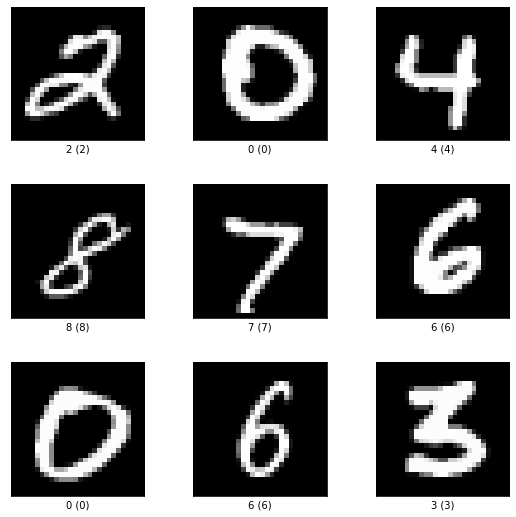

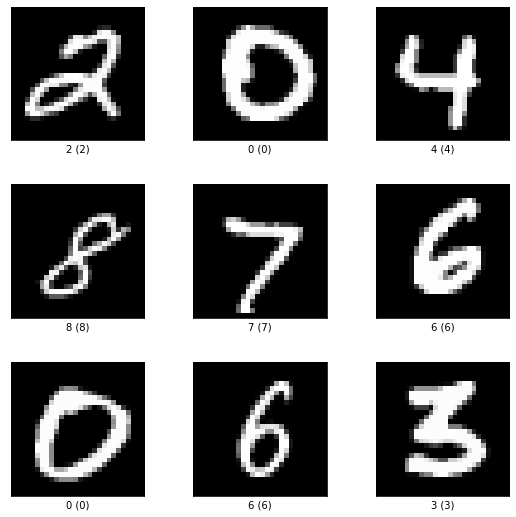

In [ ]:
tfds.show_examples(mnist_info, mnist_data['test'])

###Auxiliary Functions

Simple functions for plotting graphs and other functionality

In [ ]:
"""
  def plot_loss_accuracy(history):
    Plots the graphs for loss and acccuracy, like the ones in ML9
"""
def plot_loss_accuracy(history):
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
  loss_ax.set_title('Loss')
  loss_ax.plot(history['loss'], '-r', label='Train')
  loss_ax.plot(history['val_loss'], '-g', label='Validation')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(history['accuracy'], '-r', label='Train')
  acc_ax.plot(history['val_accuracy'], '-g', label='Validation')
  plt.legend(loc=4)
  plt.show()

def multiple_line_chart(ax: plt.Axes, xvalues: list, yvalues: dict, title: str, xlabel: str, ylabel: str, percentage=False):
    legend: list = []
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)

    for name, y in yvalues.items():
        if xvalues == None:
            ax.plot(list(range(len(y))), y)
        else:
            ax.plot(xvalues, y)
        legend.append(name)
    ax.legend(legend, loc='best', fancybox=True, shadow=True, borderaxespad=0)

###Test Functions

This section contains all functions used for testing, in order to clean-up the model code. 

####Test Model

In order to properly validate the trainning of a model, multiple testruns should be conducted, with different batches and validation sets. The higher the number of runs, the higher the validity of the conclusions, but for simplicity we will only consider 3 sets in this report. 
The accuracy history will be the average off all tests

In [ ]:
def test_model(model, epochs=10,tests=3, plot=False, verbose=1):
  model.save_weights('test_model_init.h5')
  train_hist = {'loss':         np.empty((tests, epochs)),
                'val_loss':     np.empty((tests, epochs)),
                'accuracy':     np.empty((tests, epochs)),
                'val_accuracy': np.empty((tests, epochs)),}
  for i in range(tests):
    model.load_weights('test_model_init.h5')
    if verbose:
      print("TEST {}/{}".format(i + 1, tests))
    test_train_model = model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, epochs=epochs, batch_size=256, verbose=verbose)
    for key in train_hist:
      train_hist[key][i] = test_train_model.history[key]
  averaged_train_hist = {key: np.average(value, axis=0) for key, value in train_hist.items()}
  if plot:
    plot_loss_accuracy(averaged_train_hist)
  
  return averaged_train_hist

####Test Model Parameter

To test the impact of some parameter, the previous function is used with different values for the parameter. With this, we can plot the accuracy line for each model.
(Note: for running all maybe consider using a single test, as this can take quite a while)


In [ ]:
def test_model_parameter(model_creator, parameter_values, epochs=50, verbose=1, tests=3):
  named_parameters = parameter_values.items() if isinstance(parameter_values, dict) else zip(parameter_values, parameter_values)
  return {name: test_model(model_creator(parameter), epochs, verbose=verbose, tests=tests)['val_accuracy'] for name, parameter in named_parameters}


## Feed-Forward Networks

In this section we explore feed-forward networks to classify the mnist dataset.

#### Single-Layer Network

First we evaluate how a simple Single-Layer network performs. Although Single-Layer networks are defined as a single input and output layer, but given how the data is an image, a flatten layer is needed in order to rearrange the shape. Given this context, we will call this a Single-layer network, since no hidden layers are added.
This NN is very simple, so no parametrization is necessary and we can head straight to trainning and performance.
Like stated in the introduction, we will use Adam optimizer, however we will use this case, given it's simplicity, to evaluate the impact of using it in comparison to standart gradient descent.

In [ ]:
single_layer_model = tf.keras.Sequential(name='single_layer')
single_layer_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
single_layer_model.add(tf.keras.layers.Flatten(name='flatten'))
single_layer_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

single_layer_model.save_weights('single_layer_init.h5')
single_layer_model_sgd = tf.keras.models.clone_model(single_layer_model)
single_layer_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
single_layer_model_sgd.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
single_layer_model.summary()

Model: "single_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


##### Training

In [ ]:
single_layer_model.load_weights('single_layer_init.h5')
single_layer_model_sgd.load_weights('single_layer_init.h5')

Given the simplicity of this network and the small number of params, the updates should be fast and small wich causes the NN to take longer to converge.For this reason we consider a big pacience (40), to hopefully let the NN converge.


In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('single_layer_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True) #only one needed since Adam will be the best

single_layer_train = single_layer_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)
single_layer_train_sgd = single_layer_model_sgd.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
171/188 [==========================>...] - ETA: 0s - loss: 1.0027 - accuracy: 0.7492
Epoch 00001: val_accuracy improved from -inf to 0.86758, saving model to single_layer_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.9645 - accuracy: 0.7592 - val_loss: 0.5500 - val_accuracy: 0.8676
Epoch 2/10000
179/188 [===========================>..] - ETA: 0s - loss: 0.4718 - accuracy: 0.8806
Epoch 00002: val_accuracy improved from 0.86758 to 0.89242, saving model to single_layer_best.h5
188/188 [==============================] - 1s 3ms/step - loss: 0.4694 - accuracy: 0.8811 - val_loss: 0.4190 - val_accuracy: 0.8924
Epoch 3/10000
174/188 [==========================>...] - ETA: 0s - loss: 0.3890 - accuracy: 0.8961
Epoch 00003: val_accuracy improved from 0.89242 to 0.89975, saving model to single_layer_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.3877 - accuracy: 0.8968 - val_loss: 0.3700 - val_accuracy: 0.8997
Epoch 4/10000
183/188 

##### Evaluation

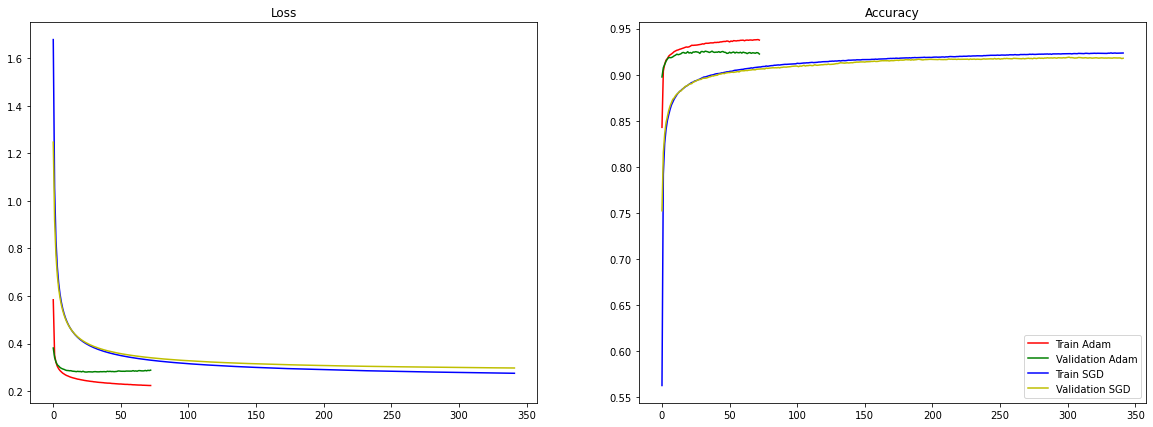

In [ ]:
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
  loss_ax.set_title('Loss')
  loss_ax.plot(single_layer_train.history['loss'], '-r', label='Train Adam')
  loss_ax.plot(single_layer_train.history['val_loss'], '-g', label='Validation Adam')
  loss_ax.plot(single_layer_train_sgd.history['loss'], '-b', label='Train SGD')
  loss_ax.plot(single_layer_train_sgd.history['val_loss'], '-y', label='Validation SGD')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(single_layer_train.history['accuracy'], '-r', label='Train Adam')
  acc_ax.plot(single_layer_train.history['val_accuracy'], '-g', label='Validation Adam')
  acc_ax.plot(single_layer_train_sgd.history['accuracy'], '-b', label='Train SGD')
  acc_ax.plot(single_layer_train_sgd.history['val_accuracy'], '-y', label='Validation SGD')
  plt.legend(loc=4)
  plt.show()

Right away, the impact of using an optimizer is very clear. Not only did the NN converged much sooner, but also with a higher accuracy, confirming the purpose for using it. Relatively to the performance of the NN itself, looking at the plots, namely the high number of epochs (this is especially clear in SGD), we confirm right away that convergence took a lot of updates. The validation line follows the train line pretty closely, so it is safe to say that the model did not overfit, already expected given the simplicity of a Single-Layer NN.

In [ ]:
single_layer_model.load_weights('single_layer_best.h5')
loss, acc = single_layer_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.2642 - accuracy: 0.9281
Accuracy: 0.9280999898910522


Testing the model yields aproximmately 93% accuracy wich is already a very good accuracy, especially when you factor in the complexity of the dataset (it's images) and by contrast the simplicity of the NN. This suggests the a big part of the data is linnearly seperable, but clearly not all. This is particullarly visible with [t-SNE](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) as seen in the codeblock below (executes SVG):

In [ ]:
from IPython.core.display import HTML
HTML('''<svg style="width: 450px; height: 450px;"><g><circle r="3.1" class="highlight" fill="#40bfbf" cy="172.49447127005934" cx="285.77277574679636"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="118.18281811751663" cx="147.67415536071638"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="416.0208586288969" cx="307.2821957316456"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="272.3185892701962" cx="33.73707558630356"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="352.99402428612206" cx="226.5130177612517"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="198.43359155086202" cx="114.31040601288002"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="253.1997912930484" cx="156.0557639424658"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="188.06692789520983" cx="335.9971631507218"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="269.7777593218553" cx="150.22628386903986"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="418.4463597555139" cx="189.2038984172081"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="159.3034011168307" cx="349.11717297095004"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="158.03153982808922" cx="222.9087065623025"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="222.4201404610915" cx="385.0987434513317"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="72.81556984574584" cx="250.65347246625544"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="235.0389957582297" cx="135.92590005442"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="336.197414150304" cx="159.42299303869189"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="170.51663815438522" cx="143.40726091351814"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="234.10141100600293" cx="268.23960553570953"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="82.84146091097638" cx="290.5573162056661"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="351.48686835678933" cx="169.8724990657022"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="407.7698826076662" cx="324.15660193328125"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="116.79483960765539" cx="129.5309205983287"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="362.6806124253099" cx="179.60940741441152"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="273.3250868598564" cx="34.090410373370105"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="274.1545269768398" cx="97.10927831110018"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="191.39653083629807" cx="206.5222764925494"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="389.73549091448143" cx="245.3464704412162"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="190.71171393531398" cx="360.81585526157755"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="310.9948292214441" cx="129.75563914946372"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="353.58335146098017" cx="127.1049579696264"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="241.19024339535233" cx="401.7081485626674"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="227.74124645685544" cx="260.8327525400708"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="59.47008329238516" cx="279.35021055296"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="351.1619159479724" cx="164.62659936735724"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="138.66131936068874" cx="179.6315100678567"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="150.79109953976567" cx="236.55647165919046"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="86.89114170999912" cx="288.02135675254755"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="134.47880837216934" cx="168.96211477939033"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="256.7960984868944" cx="212.84760896577671"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="74.36711788043206" cx="258.74806795645503"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="287.9548210882853" cx="109.87684338399795"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="247.23870346124474" cx="294.6195179957905"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="267.0771727349661" cx="207.41781442159743"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="349.84199800755664" cx="174.5336316693181"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="237.64156500228884" cx="352.96532020455464"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="353.72752691007526" cx="221.3809816841855"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="276.87876554560364" cx="312.38513417090576"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="177.9372620426067" cx="247.2639223272044"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="242.29247931791662" cx="347.54207734176566"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="191.63097938973277" cx="348.02383057815575"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="150.0318132338292" cx="371.0827493086693"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="85.60305642532826" cx="140.6974745023202"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="299.1083485465103" cx="215.0794282432581"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="282.81000133477875" cx="57.01371341965756"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="438.25875416141247" cx="227.18661525123434"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="262.485018210894" cx="274.88290333112224"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="69.15283656900661" cx="165.59513291642426"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="363.9965416691307" cx="180.56630451804057"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="392.3061344469437" cx="298.541895642196"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="263.5753855634595" cx="26.957258331747553"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="422.370116414103" cx="322.4186729849794"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="404.6899935003004" cx="181.60166247025307"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="94.59628163384424" cx="277.9500352022714"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="119.6239682604981" cx="133.66697920432776"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="438.697400905401" cx="273.6912609941465"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="161.34258104542286" cx="220.88657628571426"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="92.76168997494955" cx="264.6079467327178"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="220.54672150547074" cx="74.15115383365792"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="50.39133735219427" cx="149.27844649087217"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="117.91922350976257" cx="192.81217444787498"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="234.91538771271107" cx="183.01328472088028"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="342.665003267825" cx="153.61535190323383"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="231.46084527198522" cx="118.0928441400454"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="77.20457554710102" cx="263.9351728385326"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="223.25219026248615" cx="359.30931466835864"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="125.49510988527257" cx="172.7596670998512"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="211.58422807793352" cx="194.66548990566136"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="250.881127899192" cx="51.91303853824458"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="243.8985532745807" cx="48.926120124788746"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="350.95016340780694" cx="131.2903093935997"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="100.37374932343577" cx="195.5994574979423"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="123.70021839386364" cx="172.53168506968402"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="156.95911886316446" cx="137.58569779848509"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="79.8044914975489" cx="249.22696402633918"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="277.80832414474764" cx="212.90946672743215"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="238.26744973519442" cx="297.8987430395966"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="234.91395444656206" cx="392.86617516855534"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="372.8523271613689" cx="187.28956579085036"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="70.67567258109659" cx="169.9593054103292"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="436.1076929415555" cx="199.4091682007234"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="78.02322530580292" cx="241.87852675596923"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="347.89900829932714" cx="152.50439002010916"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="401.51569425204406" cx="285.680925843665"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="76.25662828748443" cx="259.3708897439726"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="257.0993877680618" cx="285.488078406782"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="124.51889012885532" cx="180.513388359289"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="295.9589319523562" cx="172.29189078376058"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="251.1887602446269" cx="274.19454550044753"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="218.51481366851826" cx="359.14093233607207"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="275.67646470808506" cx="54.64405404536901"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="198.43382779597712" cx="264.0594460101965"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="320.828125577124" cx="201.21469896342157"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="234.3704722158395" cx="127.16782114653918"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="314.050593856705" cx="179.60620162314"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="247.8322596983673" cx="163.53034511616715"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="242.07465994825407" cx="56.67839919020979"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="66.63422190259608" cx="276.842177470078"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="139.9857644167989" cx="339.37745715122145"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="49.38749339952484" cx="144.4584143240093"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="218.5409029582812" cx="151.35799686378832"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="335.84279375028535" cx="311.97163379649686"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="193.57054079675675" cx="361.66762328897636"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="285.51331572863677" cx="114.02863701347876"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="234.722904601507" cx="34.553384870144015"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="81.12706856902786" cx="117.27561185203423"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="422.9851009072782" cx="204.57611258396489"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="355.69275662356114" cx="250.46261937766982"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="181.21940993295343" cx="201.81305839337892"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="100.19004951717324" cx="173.65221213293495"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="116.30800984832639" cx="123.3135535162312"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="291.69583390921724" cx="191.46501414924202"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="63.263498576295135" cx="140.5424098016397"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="195.3375114120015" cx="179.69264535898563"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="344.1042854261753" cx="142.54979003892166"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="223.94462744195113" cx="105.4865520696907"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="243.69598545002478" cx="297.0748519357824"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="80.49917300560756" cx="300.4228682606692"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="423.8274520945067" cx="182.66526544890402"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="258.87761299070957" cx="112.77486770529778"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="104.62798542772133" cx="262.66294069990107"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="216.2500443783086" cx="346.94734399962186"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="419.8308220590105" cx="183.1951659891636"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="224.53188506839527" cx="222.29614272310855"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="333.8064267867849" cx="217.71168711142914"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="246.03576256428636" cx="175.88161882585402"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="147.5212034309707" cx="328.0245278276868"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="232.00946858099792" cx="368.3566015497309"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="241.25258463538285" cx="285.11998104705646"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="158.4461115466249" cx="303.39680418093815"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="407.47507068028114" cx="198.46853355153075"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="269.8797045831038" cx="177.40835013530733"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="352.26347747314406" cx="129.5683901724019"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="403.13906080172796" cx="233.04187368426082"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="219.4879732265838" cx="160.8520507282225"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="276.7519293891442" cx="343.3996346235858"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="165.9954011174299" cx="229.20488937572543"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="246.97345239064862" cx="274.18570553788396"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="72.57190773282133" cx="269.46986570789943"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="277.29328781748734" cx="171.24451180103898"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="209.97096100692113" cx="370.74645713432636"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="371.0675557514032" cx="260.8581873484538"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="81.46885481581555" cx="254.54859951333498"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="230.47379274991476" cx="95.37808509561563"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="354.297009495263" cx="173.62445058487165"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="314.41151595781776" cx="246.5410521069499"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="98.25804795383318" cx="254.51497578997314"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="90.70523668259112" cx="117.47137664138543"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="145.63060519757425" cx="326.4750235879501"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="290.4101055816252" cx="265.895801266346"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="180.013713758664" cx="202.0535202091044"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="277.22060123904333" cx="331.21513348295923"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="187.5310937567099" cx="207.33972716994023"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="337.79304662228685" cx="264.94181876814883"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="404.6244821804693" cx="182.62549660551272"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="412.4225378574999" cx="307.5837433918479"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="89.9275836924719" cx="262.0184585317701"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="405.8243546379672" cx="216.57062457889782"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="365.3336450681536" cx="194.08875789188275"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="298.41307917270007" cx="153.04185864516137"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="125.27018255938465" cx="183.34777483946132"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="329.84668395368266" cx="279.1803722914755"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="180.605447337253" cx="201.9323704176253"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="306.5498608981667" cx="233.9872758148174"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="152.70167422057116" cx="225.13144113346183"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="288.78924432897605" cx="101.8158633760515"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="160.15833372995775" cx="235.1148668817142"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="326.1068138998192" cx="262.30613640608567"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="254.9665119279969" cx="65.08628592046246"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="147.613943373838" cx="106.40884201099033"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="192.54706652324225" cx="336.0559277495908"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="184.99326082488767" cx="174.22420001515752"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="192.48012949161168" cx="329.0829938486019"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="169.49166949316574" cx="399.92587146159167"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="353.6410941623745" cx="208.99267929973917"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="242.37885025730236" cx="149.41206233272842"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="320.67031933429354" cx="181.9773279147713"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="32.880025308328925" cx="252.74311270321633"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="208.17746500991313" cx="176.96195674917166"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="289.59259309591937" cx="316.5607555925794"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="214.06570006758133" cx="163.47794265318916"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="200.11155544546563" cx="174.35777739850664"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="166.0402437367239" cx="228.08924465429044"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="108.81061179176203" cx="177.8863728965074"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="348.44426202503354" cx="151.98279926442223"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="412.09987098281994" cx="279.42965484051103"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="360.0699390810152" cx="168.89191152169136"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="289.80263148548204" cx="253.1316644946537"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="232.13276638311316" cx="269.71987347449766"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="165.8005813085392" cx="382.15377777506393"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="209.92678729094723" cx="120.91468765282636"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="247.15023653322135" cx="151.29788621717034"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="275.35153152852166" cx="33.636314297666914"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="238.05355656705268" cx="289.5788603617639"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="192.12629474395266" cx="329.98436236203196"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="58.13434242332858" cx="272.8375315828849"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="254.7667749242681" cx="19.633308142263846"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="73.49527451232011" cx="143.63407820032708"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="145.46627199667947" cx="311.6572849474982"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="261.0224988731386" cx="94.138600375791"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="58.43393419374062" cx="147.2624955005764"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="90.40611740240932" cx="178.416397053397"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="257.2907490583485" cx="93.55558039609939"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="281.7188236065276" cx="142.9487640857867"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="190.72339158629526" cx="122.29919390890252"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="284.7288555827585" cx="237.3162847093225"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="142.04743707797985" cx="340.8581426395154"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="100.60761001111887" cx="199.70373838892093"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="398.7327267958821" cx="262.2049767971967"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="45.95166531475364" cx="250.55898266131442"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="158.5455157993677" cx="279.411211239314"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="198.611206671892" cx="213.57006987763413"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="61.696160577402715" cx="229.43242329560883"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="422.01473783208706" cx="314.50018174588746"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="324.5621883964134" cx="180.32729588447677"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="306.8274763787997" cx="148.75473502322157"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="225.2889613836908" cx="280.8561962448619"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="326.101462673258" cx="284.4195307629308"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="340.19223114189344" cx="209.73536526578377"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="247.33756242729743" cx="362.9585325268838"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="57.89715232774399" cx="154.77397486481664"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="322.19621005066284" cx="149.85817002709695"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="236.56962682898018" cx="90.82821295307828"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="111.02729421289906" cx="202.36392156705148"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="178.80328169392723" cx="103.26389209773379"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="107.0722872702442" cx="188.62333154086303"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="142.6496258764312" cx="335.14643899708744"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="183.5732189082389" cx="255.64671076101138"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="411.5254437324319" cx="253.56965194994893"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="58.48427088547938" cx="244.2281410069431"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="154.41821474484559" cx="254.08036718923145"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="239.8533171801658" cx="222.66416059047341"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="45.894384115444716" cx="216.38696735169674"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="129.25431907414156" cx="358.0179768928005"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="313.60489821776986" cx="188.29342622573714"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="193.3706582001082" cx="392.2788038834875"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="234.1770008583545" cx="277.8098759201335"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="55.640022545268735" cx="157.70924899729187"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="339.72902589407687" cx="209.91590735390872"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="248.31647153217637" cx="159.82745566392924"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="55.03730082179025" cx="145.79372116134272"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="242.49755381302543" cx="402.7861075526165"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="258.79294109322734" cx="92.87452418770371"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="213.68921737978698" cx="174.88771914430959"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="157.57324078696578" cx="97.17810805068797"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="145.03953640175106" cx="373.76277982350643"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="145.0649904393876" cx="330.5613498501793"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="123.87277622120823" cx="281.4546985207028"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="417.18092103746034" cx="219.90725993271536"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="285.73218858669054" cx="175.80549845213207"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="149.17034267449296" cx="251.80520860802872"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="69.28267248902085" cx="104.54350552269484"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="80.33040608824983" cx="245.95331134551012"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="128.57263654148716" cx="244.0292281140811"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="314.7745752531115" cx="186.96081423093784"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="344.5202416509671" cx="330.16866651626344"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="241.33279328576273" cx="271.1278696373113"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="179.68527810791707" cx="385.8225325552026"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="341.2517300484282" cx="220.48868113732556"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="226.92158304178747" cx="156.69591128743792"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="226.16057846469394" cx="68.49987399997731"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="221.45170580532846" cx="96.68040002791837"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="403.9661934082846" cx="220.3525229134455"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="438.6234726665846" cx="227.2968000759421"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="153.92829731680263" cx="253.44302182120614"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="118.60336738687218" cx="278.979712283576"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="415.6618539590674" cx="222.42905498031234"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="286.0424553398628" cx="90.12658693744945"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="160.38234354574737" cx="103.72537220680273"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="111.79728846603031" cx="341.88560011555234"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="191.48937791357807" cx="334.48869963214725"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="351.416005810397" cx="205.41945819830596"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="137.89700048439292" cx="337.98552290920003"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="329.50588663993506" cx="327.42669582868416"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="65.39070453359702" cx="144.8844576658096"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="203.1469535541739" cx="410.252870661229"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="336.7330972018117" cx="216.88977593397223"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="80.9380614887837" cx="243.06554583098273"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="146.40517051897953" cx="238.81286317568092"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="275.0226783282689" cx="210.64874382157802"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="406.68891286601746" cx="220.80194147322106"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="262.84414375031724" cx="79.52170854170174"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="150.65607721536355" cx="336.2913377657033"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="374.5566763388884" cx="255.3347600746349"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="95.53047173605917" cx="160.70594685969937"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="418.3506530135264" cx="325.16184138035163"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="227.65826827889407" cx="274.4733367125837"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="89.81030722206633" cx="171.0324570868891"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="418.1257916165078" cx="219.0246990027818"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="224.04484344389766" cx="380.78953365816403"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="60.39720801743616" cx="229.9038418383508"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="261.10243213313726" cx="307.05596631058825"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="326.8461512287088" cx="172.57662658228205"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="100.27842716651942" cx="259.10365531322395"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="113.74675019159974" cx="148.06833857640962"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="313.8793216423125" cx="257.3646797441214"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="330.1378148525298" cx="153.3001954255858"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="195.4402560607907" cx="423.800176471775"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="313.4329777028288" cx="162.5880127985891"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="169.02834337575538" cx="104.02702974845398"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="222.51167170802097" cx="54.65199847412411"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="286.46775698188304" cx="114.88884393615272"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="76.48751118790247" cx="243.2154598387463"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="282.5912713226085" cx="326.5148446250296"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="343.1999171491904" cx="212.7760363105209"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="428.3958832137625" cx="274.0991684028067"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="255.8062946363575" cx="46.556098141718834"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="204.75328847927915" cx="408.8401578372215"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="163.64497649077038" cx="99.96611906535419"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="222.1458028814308" cx="154.43037557412222"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="366.8411745944125" cx="175.7821980908939"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="113.18431100728614" cx="187.78146657904585"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="143.67410007113065" cx="333.44597962285883"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="352.14625594346296" cx="317.06067223247186"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="53.493389547802224" cx="225.07215537031448"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="261.0615974396917" cx="206.0983717184482"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="172.04840203419792" cx="100.372526592237"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="105.5040921960504" cx="175.5849389138377"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="143.03062881232947" cx="329.7178558958822"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="179.0050460103881" cx="281.37896822612447"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="418.78877232656026" cx="220.78417501645285"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="147.73307134665745" cx="374.1842081444532"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="79.31832102691327" cx="261.6690465124291"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="191.01995886982647" cx="299.33994262923005"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="251.90648526603695" cx="332.5400839937343"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="355.7875953021024" cx="311.3766422329481"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="148.41673174539196" cx="248.60125235671563"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="396.0994728138395" cx="240.51694039661444"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="324.4355939791415" cx="173.26156709989615"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="414.26494208741104" cx="251.57625412703885"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="172.81690189962418" cx="99.34662943277435"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="325.52204680509016" cx="266.43893977416116"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="137.88184233851786" cx="334.62586464480285"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="384.00888734758337" cx="242.97051073935162"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="227.00277684803262" cx="273.0196545903558"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="337.17496347225284" cx="291.94905815515204"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="255.38181435816776" cx="44.58411071912593"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="208.83375531324603" cx="315.2349864650101"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="159.95203130965749" cx="100.99014824018562"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="254.01721037952268" cx="316.4488852894595"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="309.119010042924" cx="189.1500757365031"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="346.90197699648917" cx="283.8327693199043"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="257.94014842131753" cx="38.7255834846846"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="176.24484599043717" cx="417.6818235632767"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="314.96921925168397" cx="154.50269954378484"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="328.10072267146666" cx="256.7098577316494"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="253.56962752670273" cx="18.260822916696803"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="219.75915789542026" cx="352.65468534852863"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="247.3118982413899" cx="44.972497688389964"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="239.7247929699477" cx="152.6191941579146"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="99.31821713720616" cx="151.94449459133747"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="215.92578422261963" cx="186.54225656284348"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="190.1558264323907" cx="333.27452061000315"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="346.6676767830105" cx="258.6656678579287"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="402.8892782921" cx="202.85826447044863"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="349.41388889451713" cx="252.0171397055486"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="174.8014652540431" cx="109.81649649226486"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="231.36237956133675" cx="114.22006148559859"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="76.34563226108934" cx="239.77631058718228"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="237.44078961886805" cx="300.2958233294569"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="413.3029300023359" cx="235.25509758679388"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="300.79589135642135" cx="105.52698844288403"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="311.8599808093183" cx="201.81455003404767"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="398.3696675005883" cx="248.30393650581385"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="412.9557375882626" cx="213.83145586826538"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="341.9024040362044" cx="287.3698806301944"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="171.39487662282286" cx="97.80376203255082"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="199.56910644374224" cx="280.7691701373371"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="326.6566167175099" cx="174.62304769835637"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="183.43939429162975" cx="150.47967049019158"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="406.3287324646847" cx="196.91371929077616"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="428.6933103196312" cx="293.1131037662378"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="183.64530663278643" cx="105.5289223563846"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="244.76022574107932" cx="127.32589659891943"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="359.58440592278316" cx="200.6356978977233"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="257.33810246874975" cx="233.05381024340608"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="179.78564931741013" cx="97.81615665998616"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="270.49395012353517" cx="381.50936702987474"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="317.5834802252851" cx="157.88398797139703"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="102.4840884783323" cx="290.54172402806796"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="358.82453175109515" cx="193.19114732400496"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="196.3846953551513" cx="195.27205747985118"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="183.61366626957712" cx="84.66543497479176"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="220.9222502849369" cx="375.24186104264646"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="233.68953550351952" cx="262.4592067584687"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="246.98497483408337" cx="145.47212013671702"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="80.73117669680431" cx="244.9598319605077"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="171.0411957091923" cx="306.68345721068954"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="257.2639819373977" cx="16.893216427460693"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="270.29361426590987" cx="141.2949274103242"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="114.7081029879815" cx="138.27114926483657"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="178.62272449710306" cx="162.56592662736122"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="85.2151309581496" cx="265.23823221765156"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="421.77642694572376" cx="240.08229059032942"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="149.70109754301768" cx="255.4527947270378"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="212.82608074298184" cx="371.164116521576"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="137.28108199890215" cx="335.03497525532845"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="250.46330781032333" cx="152.14640175368191"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="150.3642815337506" cx="255.58437226801706"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="284.38048194310954" cx="104.31938033138384"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="367.4717622533308" cx="176.7485889517075"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="200.43922467310654" cx="176.38206839077355"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="329.8404646636752" cx="152.46172305350325"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="332.0275340343351" cx="225.88532788216853"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="415.43156441847344" cx="214.30916340705895"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="370.48526098927425" cx="269.9273626144459"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="234.85027814692745" cx="255.87460213898322"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="256.4928119527633" cx="72.18601202533117"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="151.7372502376928" cx="226.0560231331095"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="156.0257363895989" cx="220.43313057083674"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="353.179273420814" cx="194.94922028892543"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="184.17448744955576" cx="274.7388597397659"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="82.567856103228" cx="252.1325262150332"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="270.3939167994974" cx="189.362031557349"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="362.65649344727746" cx="172.94620734156769"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="320.72860045478745" cx="304.50231045012515"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="139.55852336720562" cx="315.9455018898545"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="295.1409909289996" cx="232.61457082635252"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="108.35362583395289" cx="136.57455222353656"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="328.2418324281375" cx="292.1349610844649"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="66.12441593230315" cx="143.48040899404748"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="82.9442440182727" cx="292.7337930046525"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="75.28092497387699" cx="254.10200559355508"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="166.64778376173643" cx="137.2978303786701"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="144.71344122586558" cx="336.06526767274687"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="353.49833618397025" cx="322.11587267625964"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="63.80033538301622" cx="131.72468174922628"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="311.26767584719505" cx="238.4042030790958"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="146.00451528594638" cx="238.2761321298544"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="404.3032767290596" cx="277.2644079256017"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="224.98749098388222" cx="260.5773111358248"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="49.78392369084797" cx="147.17552433377608"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="339.7748464582661" cx="206.3204489942554"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="406.19848998330957" cx="252.56481906423943"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="256.4807964163266" cx="16.585504417975322"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="243.79418100682975" cx="178.5738077230114"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="239.09384682280248" cx="274.11472761597025"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="299.496719033557" cx="256.37603239583416"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="256.4559412325866" cx="16.814101784256344"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="193.5025983498688" cx="117.24001026259225"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="79.9164057532484" cx="249.80417127738426"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="271.11563463805663" cx="105.70740279382463"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="126.06296622501671" cx="183.05110042151748"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="119.46043170010778" cx="363.0127260574788"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="99.25814494909531" cx="119.02213352963962"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="289.65275318918935" cx="125.22590827650882"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="239.63549575022608" cx="45.720757390929776"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="235.89016596187065" cx="292.78592076400827"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="165.60899750831842" cx="101.63430625804239"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="74.74142903609265" cx="163.72737354218066"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="212.64697260776498" cx="334.3928390561314"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="348.19627058302257" cx="299.1898225937498"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="433.7041900810073" cx="214.76394486829963"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="75.00980348687364" cx="115.20875278646544"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="161.5071614795777" cx="227.48583960555163"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="48.66169346513914" cx="152.0621501527417"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="93.47978721976772" cx="240.83774340721754"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="277.2635538974164" cx="67.74484560018557"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="333.00400651808474" cx="136.35514094638316"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="288.6316193905363" cx="271.5174982669478"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="257.3424290508" cx="260.19078940415574"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="247.50527722978197" cx="140.50268765786416"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="368.3009496429817" cx="164.59002532709255"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="216.6041867940245" cx="95.40012731426394"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="108.56904841451141" cx="112.1581360970852"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="171.32726656731782" cx="274.112562951427"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="276.42090053620336" cx="24.426776468856378"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="210.02185672053116" cx="129.17243237130901"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="154.51524555829226" cx="115.8495704082758"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="254.0162901223882" cx="204.04796053226087"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="198.94791639574075" cx="352.75568837635285"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="194.79355978146447" cx="285.10588325716316"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="433.17930837592604" cx="188.14995951198745"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="345.12298535073535" cx="228.43650076526615"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="334.1376534263338" cx="132.68341936712432"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="280.54256467239713" cx="132.15526319486594"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="246.4669387432682" cx="251.79001200364658"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="236.61649950804252" cx="396.06053876937995"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="373.4715420903265" cx="148.11774676990524"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="16.478285147259705" cx="232.61506323259542"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="95.86111600392891" cx="105.19052045822288"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="141.61564693640233" cx="377.3611225711932"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="301.94887739967584" cx="28.357147990668995"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="252.7319147101357" cx="53.08504506030282"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="171.8405887439754" cx="84.46224219949525"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="50.44135538773124" cx="168.42726133282181"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="129.73609428682138" cx="372.12385406065897"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="160.7962285052275" cx="302.6107287777611"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="339.47597990541675" cx="119.05377938692135"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="71.47922462872033" cx="288.473590337692"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="231.88022138518406" cx="286.81530895762165"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="252.03333515767744" cx="191.176231966365"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="373.6635489341255" cx="146.8798058844376"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="201.50156950916764" cx="278.1977354584428"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="226.78597971922437" cx="264.15492749521377"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="185.81851445866818" cx="398.59170189725427"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="318.9190233077337" cx="179.8190227603959"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="37.964042162089434" cx="202.09020413081794"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="275.0365371260108" cx="26.999958262788127"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="287.98146733964234" cx="21.78311671360342"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="193.88529895415252" cx="320.56733539327314"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="244.65596198125914" cx="67.6675110364533"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="340.9023290172321" cx="120.55952883370819"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="207.83347838711134" cx="264.3827034976643"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="162.6199309125367" cx="234.57332440194418"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="155.9110970739668" cx="357.59461465835324"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="161.35757436912456" cx="85.99439615845152"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="279.0294586626068" cx="387.3913319773654"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="249.99124199717147" cx="292.6058250692695"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="290.48170433372513" cx="167.44987133897385"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="110.25832185724255" cx="107.39331386421958"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="338.43875396857305" cx="276.64926410432565"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="347.53127904245537" cx="155.6979899448639"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="295.6569722367205" cx="197.92359024091746"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="156.14701803881667" cx="227.1466735162508"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="65.2065652015389" cx="156.55905394283928"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="376.48868889037334" cx="164.13928612965307"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="59.322787210141506" cx="145.31929701759398"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="125.40614986424724" cx="99.93353921575684"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="299.65999737254236" cx="354.54225085393557"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="374.43448816771723" cx="150.50373452749955"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="201.0603845037096" cx="148.96500965789937"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="428.10217010086626" cx="180.08507047149655"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="283.2180460952501" cx="340.344205126744"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="305.73556793891345" cx="28.379717640272013"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="29.772665838739346" cx="250.52095543888814"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="299.1355387110393" cx="26.6376131969122"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="46.93180783889645" cx="262.2149650209013"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="152.01798085740202" cx="243.10972778806527"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="246.37478941318867" cx="65.03155397076787"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="266.1398729877474" cx="284.7852931418674"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="223.8802616362247" cx="335.03699707398806"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="421.8053037904933" cx="203.69184437101916"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="124.50226506563752" cx="187.91196178775348"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="170.18833436137695" cx="251.66723596672384"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="142.6457580494301" cx="361.83630230117495"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="244.15819077665643" cx="292.118841475912"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="156.47201989428567" cx="365.0011407566815"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="76.99694356126915" cx="268.09291654847107"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="153.33905804710355" cx="128.78729789293226"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="179.96525603970136" cx="330.0124150959349"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="342.57053818621006" cx="291.29561515486364"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="151.28853285891302" cx="109.52198124479177"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="274.2269498398065" cx="95.76178012701183"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="268.4658489920278" cx="24.919199193934126"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="196.65110018096087" cx="407.1322375126129"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="165.98390751787548" cx="100.36315370464625"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="258.2379463770764" cx="113.00643187069898"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="177.96609493479673" cx="330.93833112504797"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="224.95131972780365" cx="160.9834524588835"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="225.90791053689392" cx="267.1977700720847"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="302.26803905613605" cx="140.5829066096299"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="138.94546729345856" cx="321.62287856764766"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="299.1142711566057" cx="217.36866057778707"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="164.62048751184227" cx="93.79616582845483"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="417.67189332741265" cx="256.13177692308557"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="105.49723559363935" cx="247.37550007096667"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="337.74555586007443" cx="264.914680797308"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="329.77097563539405" cx="132.4781718087335"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="166.76128580437245" cx="146.1138332923359"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="419.9696462815443" cx="186.14297210088532"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="200.99560938958604" cx="142.9232496133533"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="244.92146852622398" cx="274.32488138105424"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="275.0344136670109" cx="115.55120931009138"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="270.844793348748" cx="36.39299811125319"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="222.56847011571384" cx="335.04665565334597"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="231.83805661113755" cx="262.9883683459845"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="317.9210140600006" cx="259.3459603902546"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="112.61465261178014" cx="112.53601839983487"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="86.80564295461396" cx="300.5320739386534"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="180.69600063928732" cx="234.22556884544525"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="334.754824560342" cx="270.1937015113861"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="174.5414692637404" cx="330.1798084951814"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="98.68569556478737" cx="199.6779244895393"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="372.08974990603804" cx="149.04323975544014"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="164.8972184468117" cx="148.54161445901744"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="433.4984260798067" cx="183.97708237949996"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="320.2837344207914" cx="128.58054495869155"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="295.5124506610614" cx="24.257515084978625"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="222.0515781654853" cx="213.5154739062326"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="377.68383644556883" cx="169.01252838814332"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="362.38834974753917" cx="255.5125345237658"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="162.43515426807497" cx="89.29742152408829"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="25.08874931669506" cx="245.65302732197003"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="281.0993339739478" cx="24.455653313625966"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="245.8995027000661" cx="335.3502580966427"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="372.1831821020334" cx="151.4989747627205"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="50.457156340082335" cx="166.72370330173433"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="111.82658286030569" cx="252.074525292234"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="83.7732665857503" cx="244.40539077215556"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="336.63701686289795" cx="129.203353011028"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="332.3353779015591" cx="229.07134701708816"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="376.0526243604338" cx="151.5680627237132"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="254.79440186755656" cx="348.22083702787944"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="129.11729690736956" cx="110.0175575674528"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="287.0764782324712" cx="78.20272459360164"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="421.37034906318763" cx="170.6325050951289"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="406.29265838501254" cx="325.40661329591"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="109.93695158365954" cx="246.2671808366879"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="299.28038443697267" cx="259.68754610339806"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="272.57744524046666" cx="33.2903635439661"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="323.6356350548966" cx="332.6233741319967"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="330.36626937292726" cx="115.44333869171122"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="89.17048952144093" cx="183.48556342933938"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="182.42823223446393" cx="334.6014599750033"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="147.97568409174502" cx="227.90131029169112"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="252.55623212908813" cx="256.88781073813476"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="414.23023053770515" cx="287.0246605881287"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="333.1699604703508" cx="135.08652116038405"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="240.07595897191666" cx="141.73265664421447"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="171.89929840211994" cx="85.64351172769533"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="196.19684477715677" cx="407.97933557843373"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="366.6976144814313" cx="177.15133742634208"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="197.34549874428862" cx="410.2478161145798"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="111.44151431079828" cx="250.07306491801123"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="282.21220779428324" cx="185.93948813974922"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="189.2990423168498" cx="274.1437637888407"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="380.2994544550638" cx="201.6314985283336"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="214.49295347883762" cx="237.2658546183522"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="264.23369631193395" cx="374.0820623495605"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="184.1721112632234" cx="330.98692070174934"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="100.62087270200048" cx="301.49399262449697"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="375.43247543916056" cx="148.98402464263066"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="308.3528781227214" cx="218.63468578807414"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="129.12735105994346" cx="113.40460927705954"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="268.03270456159265" cx="183.63393634978218"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="202.1212047346673" cx="112.16778368829817"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="300.2218871496115" cx="171.7471809712262"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="280.470641770023" cx="20.242205203170222"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="266.1302034202447" cx="145.11195621760166"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="122.56692310625107" cx="149.23086232942822"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="286.9834635859816" cx="253.6514751708685"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="371.67711210100293" cx="149.29526934069798"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="180.29398287628788" cx="110.72063401820702"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="175.09996370403866" cx="334.74370151059776"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="263.69432673781586" cx="58.25638470150013"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="190.79223506106416" cx="352.80968412033985"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="202.5779681825424" cx="197.1019187423709"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="424.05114874816707" cx="172.83310636622014"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="219.17555211025422" cx="79.1741095662675"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="112.67426329780565" cx="252.07898098498669"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="225.85540574681664" cx="182.8662551011502"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="337.07536692697454" cx="135.42086843308155"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="165.39044330646638" cx="290.48949188133577"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="174.69730862863562" cx="254.8919048711536"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="278.8904806060445" cx="203.50808962403218"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="430.8623701208172" cx="183.86287160151858"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="129.04657720686077" cx="172.18897032465316"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="176.1903832502924" cx="96.62080033003775"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="34.68071854023951" cx="217.38341010202404"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="190.66949473561232" cx="322.71963827350265"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="77.46721418624968" cx="290.8223447663283"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="419.80664814025357" cx="170.48646166140261"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="100.3358621998568" cx="177.84449707633354"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="433.20482284835936" cx="184.4021972230571"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="225.48139745189957" cx="160.75169600094677"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="114.99241024885225" cx="244.52704739181766"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="129.28485512878947" cx="184.63812917605188"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="122.80653059371136" cx="97.72843829933333"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="77.87059997328787" cx="185.09391742606806"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="120.87672665934922" cx="130.0179701205555"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="151.084395103156" cx="406.42250224605567"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="255.40067001479812" cx="36.42097392814184"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="97.0514837160975" cx="275.3657114294217"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="193.37192733084294" cx="117.38418571168731"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="219.01174702707314" cx="85.81039967227694"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="141.3902526143566" cx="347.74912695591837"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="273.83047284886754" cx="88.67709679249684"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="441.92835502870764" cx="219.117894266903"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="277.1271141023235" cx="121.37291527100801"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="156.40266272374316" cx="297.3257112836095"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="423.93045496470086" cx="196.43908087820202"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="83.12943821224022" cx="232.8781729884562"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="385.45360863765393" cx="311.0661337405883"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="329.38928044636776" cx="141.6903962389695"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="170.31425850181054" cx="129.59726701717148"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="232.1868263390718" cx="268.0470190672676"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="283.7638876867081" cx="245.33059119833274"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="365.94576165551257" cx="214.97848015615833"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="224.08399901145228" cx="184.097094897983"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="120.82678554082648" cx="130.2056146708334"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="194.64039602984982" cx="309.08789406355334"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="254.6184020038253" cx="36.846808495189265"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="413.4106248103978" cx="272.534593922354"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="205.3673527153198" cx="124.70545479381798"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="279.23959045140106" cx="335.15281212112336"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="143.58868372683216" cx="333.101226576951"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="197.24586648753936" cx="201.0693422887509"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="442.81854859878507" cx="216.50132303583885"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="251.7019807809442" cx="51.31318472058226"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="111.80321107612573" cx="330.0225022129434"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="419.9927213858123" cx="198.90137580798145"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="83.27567943257448" cx="231.77735110278735"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="98.18563607901143" cx="175.56038041000969"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="329.5474987446315" cx="174.83346517891772"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="372.30931501721994" cx="330.1881814615872"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="228.56089914131317" cx="261.0019562361879"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="394.3628844192142" cx="313.1873841233601"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="355.8173402103182" cx="200.0772611451857"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="274.7872902884462" cx="334.8106193129748"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="113.11414071402184" cx="127.13239536741547"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="259.0868986923473" cx="132.70463747490592"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="274.9333639395709" cx="29.636915249658493"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="133.6821349032464" cx="105.33613535429843"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="173.77006852806326" cx="92.08205917827345"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="199.0154907397749" cx="174.34805289027946"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="144.43400720725336" cx="331.77268294279696"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="163.14193372365693" cx="130.7218926584662"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="440.55184814211106" cx="207.07788105074172"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="413.1707096548806" cx="272.3715518284837"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="191.7904558305864" cx="401.64947186895756"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="255.03131451248265" cx="146.291907168415"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="98.64612725504031" cx="243.73973032826817"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="206.62870933754695" cx="404.6306434826362"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="339.03433339787335" cx="142.2320843116593"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="284.6286931480184" cx="229.65575287655395"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="230.28915654767994" cx="265.62710266529075"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="280.44138034018226" cx="342.95891112021314"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="365.7746432751485" cx="203.00533666924017"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="304.46874471460376" cx="144.52230489246924"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="443.5614570747637" cx="217.11709249461455"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="275.40759579078406" cx="196.11314777745366"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="144.60678479749575" cx="331.92312163447906"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="198.1503831044802" cx="186.65195396031152"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="105.7924211179507" cx="122.94926354870982"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="285.54689549941907" cx="330.2953378505495"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="102.29660875022775" cx="246.2563245495371"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="250.29058104025106" cx="352.0184168187026"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="112.22933133494028" cx="248.38034531833918"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="261.3442427436479" cx="163.4768932853522"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="90.70882980596997" cx="232.73987138956366"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="239.11980974889917" cx="318.1207370284684"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="367.93695635537233" cx="211.75734600058766"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="437.6412643712025" cx="273.7673923560134"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="115.59197837474746" cx="120.51163151013486"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="341.4180246331858" cx="250.83825460478954"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="123.41926251718418" cx="112.25453509220074"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="377.91200527419915" cx="251.02518767268586"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="274.7504992323199" cx="26.40618088924969"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="186.0426698673776" cx="384.34793449917754"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="441.52346386581956" cx="184.36634840035515"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="268.2398393338683" cx="215.27540318088032"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="158.62341625256175" cx="290.22810589070446"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="213.34492583596446" cx="371.59920310662034"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="339.9994331516624" cx="143.15979140838942"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="335.32663663224633" cx="228.10227882609627"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="374.22166977749754" cx="191.35360260117122"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="295.5215268687401" cx="326.7015222185572"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="156.48881527374925" cx="285.0330758091254"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="282.6480360791076" cx="310.38643456808654"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="97.16190358409202" cx="232.9689831383773"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="222.68861998600798" cx="399.9812187474"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="246.94002233334047" cx="273.1047303021627"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="33.192352338667874" cx="257.5269389326684"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="368.8383798095268" cx="234.1218366371341"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="341.60473519114805" cx="340.40012379608663"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="233.50391963949187" cx="39.206402728759045"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="265.0377840316211" cx="298.3401093494453"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="146.91969040343005" cx="349.81311811567105"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="177.04849693136492" cx="393.3322702984779"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="258.45980801054014" cx="269.5623446823256"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="32.04024534700451" cx="191.95419811861356"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="160.96789629283603" cx="282.033141938048"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="374.683600400507" cx="205.5121734178473"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="305.1856332634841" cx="178.80569603868685"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="157.4460035632179" cx="101.93292008355925"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="145.151357258219" cx="255.4170777620745"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="123.74612686321194" cx="199.81523509511462"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="247.72397427751758" cx="270.2864744186881"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="291.75210969326884" cx="275.59007835992026"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="256.01776148475585" cx="18.168610404784175"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="239.21843796390914" cx="138.88248019983595"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="115.4488687757067" cx="120.10196050421989"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="374.46368366868865" cx="236.1317681843076"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="253.82907410976102" cx="19.360538433527065"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="243.0183424341354" cx="310.70145918799585"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="106.59947838379419" cx="249.03320182639405"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="311.7729327255037" cx="254.22084238053498"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="110.90329299782113" cx="124.53343538557296"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="362.34944072648545" cx="282.7009519377794"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="146.09720028808925" cx="347.8276812037334"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="90.3609781032033" cx="136.1209780847156"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="240.96967836298552" cx="272.5705086739253"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="278.30644971702304" cx="361.22617456804096"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="366.13501047494435" cx="204.47558616692527"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="122.67112368423815" cx="265.5770763886451"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="325.72816242692727" cx="126.72313092286139"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="251.59370772175748" cx="302.0764412206544"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="421.800359125293" cx="213.13952826401967"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="276.99953624608406" cx="213.52609394826828"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="156.53505888151668" cx="294.9032538731269"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="348.6711672170016" cx="260.3930948867524"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="206.79982497087482" cx="125.0653934559631"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="54.15106298387306" cx="263.2646542610859"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="328.2514580430607" cx="127.84677861926099"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="416.0153645564522" cx="313.66573103483444"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="156.63608937970312" cx="295.71295378781633"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="345.3685594008706" cx="262.8255267857584"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="206.1900406172686" cx="126.72279029036983"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="232.21546917069324" cx="344.84661947150363"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="230.87126682915755" cx="40.79968373773556"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="50.65323978563534" cx="275.99123904761836"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="146.44523329524662" cx="333.89455964982744"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="335.2389182715935" cx="286.385765891674"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="206.55249556459344" cx="119.60461509023165"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="195.8918715627851" cx="183.4380754141632"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="158.60847237551206" cx="301.25919794449834"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="82.27616480899151" cx="260.9083509769105"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="233.76478850055426" cx="278.06445475500567"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="100.43429400177689" cx="170.98540035639985"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="307.56245141416815" cx="186.66886471529645"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="295.5568867189945" cx="260.49973757994115"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="295.02152781776107" cx="20.3793372513911"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="350.0641343446427" cx="177.00195359656942"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="248.07936659471466" cx="268.8928232790277"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="260.49126052623876" cx="219.63917048694245"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="127.6759379896352" cx="114.3397993004594"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="356.8657081260798" cx="342.2873706452918"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="367.8494577576173" cx="183.8418430392363"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="425.23395661665165" cx="323.76568769069263"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="110.7902689394878" cx="249.72747127901937"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="208.69276642616896" cx="192.95490220888087"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="241.5103115737659" cx="271.2121267323239"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="159.4929521102469" cx="312.5024490998185"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="233.11701503964935" cx="39.543914587184716"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="397.5221738615515" cx="260.58383259981673"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="231.86555890765737" cx="35.45010539828577"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="195.49331781246207" cx="311.0792810559486"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="155.96626854945694" cx="297.0796043084471"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="292.6679166290836" cx="105.42063418849864"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="322.85229020572467" cx="144.1558777307669"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="171.0255430967972" cx="357.6749929382199"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="94.93204637723248" cx="246.47852956252868"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="423.7931031535822" cx="300.46771637403566"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="148.1723554030496" cx="326.2295594192637"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="150.56689193736796" cx="116.27591042998813"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="155.7846070440714" cx="294.51641623229233"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="80.95182963433022" cx="306.94359055280336"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="439.3941811491336" cx="210.2549328292929"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="406.894687855363" cx="320.7230593826471"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="133.73159254339404" cx="154.4779542414937"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="385.33498062542697" cx="224.25957742011286"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="443.30035677589956" cx="216.0288039617103"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="103.80466570744136" cx="279.7572828626086"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="330.6739923705575" cx="150.86466761675717"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="361.17664305799514" cx="292.8141548023018"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="442.23923162392117" cx="216.02838915924073"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="215.69547133221775" cx="340.1391553549612"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="134.9695608992239" cx="330.3934839607025"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="255.69802569772511" cx="286.59890843216795"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="124.77978165296656" cx="114.99675850711243"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="117.3909354797655" cx="144.0974592584619"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="145.66089401896215" cx="334.52060920490635"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="191.10274630046013" cx="161.46000280866838"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="213.5047168124656" cx="133.26635144165684"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="268.36339003500575" cx="179.18828676152168"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="235.26205922004073" cx="268.58158132799656"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="233.84481000909153" cx="200.7490625885482"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="142.56721478976002" cx="333.30518852238976"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="281.4351811284227" cx="193.34419020602581"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="131.03344257763405" cx="138.00191224468173"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="245.87423820792895" cx="170.10531038554834"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="258.81010457554476" cx="17.79969442826433"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="49.72811490295424" cx="164.477270478309"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="155.59685810641707" cx="108.95202616937375"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="140.57901435938265" cx="373.56424602164304"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="216.46927984514375" cx="390.09629459295684"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="278.137517977492" cx="335.76493969662727"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="423.41653942821927" cx="263.5325342453469"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="219.61999235363578" cx="334.6020533348273"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="153.32216377433596" cx="218.23604619286917"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="317.6276141092338" cx="161.49683507033797"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="75.53350946045177" cx="262.0667761518854"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="424.79396931898657" cx="308.55829844431446"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="312.43379272359255" cx="205.09924167993634"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="272.851544514735" cx="75.38500163515421"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="244.14094350973429" cx="264.46564476232646"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="176.96579465885415" cx="407.05728737632165"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="375.32845067149174" cx="203.1229523986192"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="273.16683285012175" cx="188.2817348395747"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="122.50370830870182" cx="105.68029504038225"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="207.63766689814435" cx="349.0120274125025"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="257.72384404213165" cx="17.146097593947495"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="227.21481198954945" cx="119.60632924083441"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="163.8556082401571" cx="90.23994064012948"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="395.0423473466009" cx="201.48470515371866"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="193.4127125776365" cx="371.3118631177601"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="441.2887351146902" cx="190.456678792349"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="443.7376629662116" cx="208.581313372475"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="260.6850144850752" cx="204.7840549848899"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="146.72500794635044" cx="229.49509761378135"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="333.25208586525486" cx="231.34159492766383"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="100.9588570506564" cx="250.41563956419478"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="110.92602746959749" cx="153.5118820368819"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="129.77599224091512" cx="108.94690569385524"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="281.6541144212734" cx="230.27730759361395"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="279.4204717984994" cx="27.827871027631883"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="383.95690243411116" cx="298.79222206499594"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="153.27700799291262" cx="102.41391513795193"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="287.359340552289" cx="252.81151115811718"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="133.5525736868544" cx="337.79216452357963"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="62.61300039883713" cx="215.35284487902527"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="340.6910269910071" cx="139.9469951945127"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="191.64694241722097" cx="270.7200611219551"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="230.6672609311392" cx="247.95558209541846"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="419.5921595520107" cx="283.25315017105595"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="156.23442873141258" cx="226.27669924875352"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="66.71696263361396" cx="270.21906489682726"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="175.53602273990575" cx="83.942426029208"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="323.28179481316516" cx="115.63060964506286"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="262.97298799025526" cx="17.978998976571077"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="243.74346110353798" cx="94.76208969311064"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="158.34689958641766" cx="229.6356819997747"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="106.0822114631213" cx="296.1906963513218"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="246.5597240122332" cx="261.89529790977616"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="197.52103985297072" cx="420.7628774140008"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="258.2400973064385" cx="270.2267236338153"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="413.73439049956676" cx="302.24384011397336"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="130.66889988278024" cx="153.58851335934122"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="306.7315333916971" cx="185.55546621104253"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="374.0606824667216" cx="228.7587655425191"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="369.86899088314703" cx="201.46494022809867"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="172.00961937681046" cx="84.28451994405259"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="334.43831104680015" cx="304.4120263576406"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="353.6713445252553" cx="151.02294085574545"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="299.3724431148568" cx="197.80941242737075"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="219.22789551195342" cx="239.7121219652922"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="257.3421735764314" cx="214.40246511883376"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="433.6129665021347" cx="184.32492584115798"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="201.6356303708919" cx="197.71667797857586"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="122.88232681715908" cx="262.632292016768"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="355.7459392448263" cx="310.87562128449434"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="267.5626784228359" cx="16.404419790196478"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="311.1640906053218" cx="205.90637723631218"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="146.2831471699817" cx="169.66883929424787"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="48.81864812674066" cx="220.91555786123985"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="411.17526254294864" cx="198.33253053519726"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="208.11908362259717" cx="215.45455526867673"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="158.69704781146623" cx="219.5799237832164"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="322.970280905548" cx="116.14067933083314"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="126.41223539847412" cx="149.32860187822027"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="249.9238626927091" cx="202.58012705293334"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="275.1879894740589" cx="21.746306428223615"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="114.54194026096259" cx="190.31798917459002"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="199.87885126003218" cx="343.46925550960566"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="317.270521376615" cx="162.81139079604762"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="113.55892983100364" cx="260.99441012768506"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="160.35872452830742" cx="305.25044928307113"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="143.54894510083932" cx="167.15403202004157"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="83.47066406363854" cx="281.76444883106524"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="249.42313430361304" cx="24.208068432975903"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="195.81186138577226" cx="291.81850800572"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="267.14214288866145" cx="14.979059611421192"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="297.0516095623847" cx="208.15708444809954"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="233.81193244944356" cx="268.94395386423474"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="154.8225235360545" cx="261.79873683952354"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="127.92069891704865" cx="130.3104195967894"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="40.58972531230318" cx="295.9163058912138"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="443.9230769230769" cx="208.53759841155025"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="255.6334648524269" cx="203.7998619558372"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="307.9685677552114" cx="196.66339836204858"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="179.74677326079112" cx="405.1846437716747"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="351.3480001816759" cx="145.29943594570622"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="290.4822262706074" cx="298.68999935308904"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="114.11019407196461" cx="257.0761255652509"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="294.38956664073163" cx="346.2075341805021"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="135.16174355334113" cx="352.5253988357589"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="274.55912970092453" cx="302.48194771965626"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="121.89252571365844" cx="256.4096698543771"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="240.2297916268515" cx="157.7412629574274"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="142.633934805529" cx="165.62115833759503"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="334.7845035396885" cx="239.20538443445963"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="342.1860080558023" cx="141.87122264534344"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="282.3463840315288" cx="139.97973437221097"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="199.48386865679822" cx="343.457388313125"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="55.58124695825483" cx="162.56608046138967"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="152.40766992183543" cx="235.88278300194318"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="38.140467816435134" cx="218.72101895571183"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="432.8200839431987" cx="201.63658603941747"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="412.0219210829739" cx="259.6672784701494"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="167.87328057311674" cx="90.58970428010693"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="423.9166099021401" cx="304.81100589857806"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="443.77724226410356" cx="219.53471031403234"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="147.28523851354126" cx="370.40804424801973"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="267.48319842381403" cx="15.98456277396894"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="300.26456510436236" cx="214.98136729122803"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="352.85215634745373" cx="151.6689393878712"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="76.24960686290005" cx="296.7268024464077"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="128.85706467195172" cx="110.76655347570022"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="146.43511870787586" cx="375.8552962073922"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="122.62291869260795" cx="258.63617842408155"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="112.28890905653111" cx="186.12753650435178"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="344.92700079848635" cx="149.64599993742573"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="278.27560599431825" cx="144.49242263244227"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="280.12528987021864" cx="15.550223382777052"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="377.9427171391653" cx="293.67327389863175"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="376.8917450330648" cx="194.80697875333092"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="397.307542427425" cx="277.1179908949492"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="205.7497181811844" cx="338.82468753441066"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="425.7139187854247" cx="249.8778934884841"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="221.4974988991554" cx="245.5132594924938"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="163.16565163440092" cx="107.34075756721313"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="169.31534273212407" cx="85.39039981016586"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="252.56898661826858" cx="85.74994289909496"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="227.6600996936056" cx="245.11827688925985"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="298.4674759839755" cx="248.8526034240266"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="120.17922119805398" cx="110.8647655147225"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="239.96578427690503" cx="319.4712129998218"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="267.4715400020862" cx="17.792200513449693"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="82.6173247315205" cx="187.69896484017931"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="322.05621559069823" cx="202.30262694782164"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="95.44409392908287" cx="291.5538200775494"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="155.803193491152" cx="319.8885207664349"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="275.53100364603796" cx="187.12543861767222"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="353.7074955219417" cx="151.01830935267452"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="257.02570401546905" cx="380.9489496642208"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="237.5125037464893" cx="284.86253980044046"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="265.21323998218026" cx="300.1584715183382"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="354.98176870848647" cx="176.01503688110225"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="52.85860441753619" cx="141.62254444427688"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="119.91151702411125" cx="110.05371955228412"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="114.57761876741877" cx="231.31457782641678"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="279.61655524405245" cx="45.090993842878255"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="216.24687567202608" cx="345.13679440174536"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="177.50240071453254" cx="92.2744286308538"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="166.27151671628553" cx="134.13790362392922"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="219.60519269598774" cx="289.37595877230694"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="375.9074489901538" cx="152.95575554180732"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="417.1641970809385" cx="191.56591004265357"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="348.42135174293895" cx="305.53410824339346"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="148.74933739712446" cx="256.3577673519916"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="72.95545991833399" cx="142.9514781575744"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="114.42213651723245" cx="262.9268045172049"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="259.4347311658604" cx="218.39708432381525"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="348.3036027823032" cx="156.05231366497054"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="272.28754501384714" cx="82.13123911892794"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="230.5189444966287" cx="314.4433290842292"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="70.52501412651675" cx="176.31797454163316"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="314.0540386401278" cx="115.92725659264451"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="160.98806503278072" cx="137.3079449660409"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="102.93120708203067" cx="114.76596351185351"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="420.28786295754406" cx="294.27062241925927"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="270.1195043630996" cx="34.05008388162567"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="246.85748900355736" cx="131.53183980641566"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="178.62583414210678" cx="90.71029917026911"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="304.46293198595725" cx="209.55618433410706"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="133.80003769791068" cx="311.748634890037"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="344.4522470103909" cx="261.11058503656545"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="343.30701859742834" cx="124.67067731524274"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="207.9451426625146" cx="196.3021493636254"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="237.4263285334344" cx="300.67337598785986"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="283.94953788868855" cx="115.63198316317404"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="366.18487467645286" cx="170.34014901812657"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="178.8508219027916" cx="283.0282558096027"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="275.24437239252313" cx="307.11601102833686"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="268.610359579542" cx="346.4967421539935"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="246.52104162166782" cx="66.30793688113143"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="377.5151464452253" cx="159.08883256445753"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="239.2406930778647" cx="323.27520986726034"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="224.68477239949004" cx="350.74090212941536"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="299.8756122456365" cx="22.10467378564955"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="118.04580693888951" cx="294.47884227084273"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="149.3580092010606" cx="258.5364472740283"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="292.5191151709901" cx="223.85789616905066"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="421.4753737520414" cx="193.24309652600624"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="200.14425616465678" cx="209.24458114781268"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="158.82743863279742" cx="205.0408300752219"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="93.3936291756892" cx="192.49707565798766"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="148.15912018253022" cx="291.41322676368833"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="80.58968235506231" cx="138.07691182762497"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="218.31216205935758" cx="64.28450296416591"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="213.78266193744534" cx="73.52155510777973"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="276.2179495000944" cx="54.66169001791664"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="325.53167242001336" cx="147.91440016058027"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="375.7740638993402" cx="231.73613525806593"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="236.99704437565074" cx="109.08914722944975"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="267.25646354809174" cx="19.969896996518802"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="271.1357511843131" cx="334.34098600039783"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="154.78391668898524" cx="285.98731927576364"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="345.35348366608224" cx="176.61167117231196"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="145.36039572659675" cx="234.7873350058844"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="91.39643494871979" cx="143.43591250131752"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="96.21312122546382" cx="250.58344227183846"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="68.87146314282136" cx="264.6299779632212"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="104.48152444448927" cx="123.85538992887702"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="373.7563657940071" cx="280.4944884913896"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="274.91574719627675" cx="50.10503818998247"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="203.16405110762196" cx="165.9666256129207"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="120.44402450174587" cx="354.09791225089424"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="384.2523187094652" cx="260.02605238893625"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="416.907008561655" cx="184.46819476829964"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="105.2366627257299" cx="297.0277512527136"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="254.40551219066384" cx="291.5181470651657"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="59.268868383168765" cx="140.48177172406702"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="368.37515258542044" cx="200.48858861394274"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="168.3476717524308" cx="307.3626893870335"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="252.2119227295302" cx="330.7945182847343"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="300.90897584955155" cx="141.15426816759378"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="123.85293163153781" cx="133.40270333159057"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="220.9876647717412" cx="395.6261774018983"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="146.55475762943266" cx="254.51789039540506"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="387.1516506200069" cx="278.05223044381614"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="142.70986838078784" cx="232.15270613221247"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="337.18551209134677" cx="268.6506170953011"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="110.97138653170131" cx="272.4839275862685"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="299.3687950507535" cx="205.0861822697352"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="278.00547344035493" cx="14.601463000438647"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="354.3977817720446" cx="300.641394992159"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="117.0289859871056" cx="272.73638021510465"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="225.47221479656721" cx="91.24423510673938"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="134.92892673942256" cx="315.92589903937164"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="272.90962510158465" cx="153.52852907638947"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="131.43731184304738" cx="306.83681325483974"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="350.80238384718814" cx="214.79541972257653"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="299.7950196969445" cx="24.746619390299745"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="150.44526416158618" cx="105.5485801475919"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="348.1292978399211" cx="152.48168851276745"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="298.54779382904525" cx="149.21795125918305"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="158.72897936051513" cx="204.38650252926993"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="85.30635453702217" cx="181.25085770354733"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="184.47801846991067" cx="92.71098762731337"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="215.6182699997423" cx="357.4177604663568"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="279.5309630894357" cx="21.760283348523053"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="225.50834106992767" cx="96.79720400809367"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="417.1422207911595" cx="188.76834208896972"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="164.0980671512162" cx="145.34619599628346"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="144.76415700860304" cx="249.61038160707693"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="91.35143849539732" cx="286.2637425426762"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="131.9516669053246" cx="138.8295942584828"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="326.5064087768705" cx="219.02047474783086"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="110.55155149176356" cx="253.45777889979274"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="214.7297136632534" cx="122.2078164960015"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="262.99787339139374" cx="365.2269251578708"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="361.9479668766581" cx="229.57033000804446"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="201.7268566968007" cx="201.91655847712929"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="223.37947624612698" cx="353.4670718646436"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="143.01578932265622" cx="346.6648937352374"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="85.33095699342975" cx="285.03755347816787"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="368.52302005119833" cx="228.25468594092146"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="385.4747058758417" cx="210.1544599794596"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="377.9309927885682" cx="252.24153960048184"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="165.6026243842825" cx="376.00870169819444"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="196.73669508261378" cx="343.8806736305581"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="92.96339935068599" cx="167.88636440656407"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="351.239118653966" cx="132.3725427719108"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="293.54815493989116" cx="180.97923350891529"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="279.2850319245916" cx="19.023224361709403"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="273.07976279001736" cx="205.01712864669526"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="349.9871184371122" cx="152.21264927922067"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="235.2574067708186" cx="388.0604550604111"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="113.15695052651131" cx="255.67757371296977"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="417.38352045293277" cx="326.07008847248244"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="366.91230085628223" cx="197.61464755920449"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="168.71036294487075" cx="412.06371693901747"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="421.0132123779893" cx="187.43916114241213"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="380.69030276878306" cx="298.2359527240378"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="144.32568058086028" cx="230.16301921185928"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="259.03073553678087" cx="216.94945941645761"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="371.8178592488925" cx="175.42742935091925"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="125.86690475575347" cx="195.7625600266095"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="357.2825983431872" cx="197.3319225911978"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="179.61623959357638" cx="361.50247147128727"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="419.7714641003175" cx="188.222418086425"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="403.21604374482376" cx="306.43582288338746"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="369.5857165078959" cx="169.5838789579623"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="261.45934081432915" cx="101.90865825964326"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="180.6218856020077" cx="116.4823776724617"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="435.8648769157875" cx="277.5493140403689"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="366.51390368702386" cx="227.1706015752658"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="167.5807376976513" cx="349.83317148009434"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="129.76332290985755" cx="157.241148530927"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="402.24153813900926" cx="225.26214264888202"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="241.0032299766465" cx="57.31805206866186"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="122.75380947453158" cx="287.6423646471641"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="192.8591957669732" cx="113.40936714379669"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="101.3389150060942" cx="237.80977328445456"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="128.72062487685886" cx="325.99406149799205"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="289.9517900582844" cx="241.5402223775934"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="428.10981784970943" cx="256.05780198465334"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="188.2144574755324" cx="157.58579718945842"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="66.426710786358" cx="234.55412055847262"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="33.782789316159906" cx="191.9633622314514"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="300.8886422874335" cx="187.6585559373482"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="247.82515860973245" cx="147.75064383729216"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="249.0862968425799" cx="250.0717408465521"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="350.7695073176788" cx="340.63085286247616"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="136.2880174163693" cx="164.96625940810878"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="416.75781153034546" cx="325.000227745317"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="233.46709458879238" cx="61.948357431790306"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="385.2236597295515" cx="305.66241681126803"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="188.81130878260367" cx="144.7350573538196"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="269.76655416110424" cx="97.70637410439524"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="274.3614364921452" cx="282.9809353636361"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="96.91431870344195" cx="250.42975658334157"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="413.62023466230977" cx="227.92593764311445"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="72.25443825067408" cx="275.66195730971486"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="336.04180004237895" cx="150.2811861349802"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="193.8789368182615" cx="407.7006322714566"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="271.2644196139329" cx="279.2677994662888"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="292.28907835772856" cx="219.47818935699797"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="119.09039493280919" cx="116.96263652114678"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="182.88387763859654" cx="307.90602018738434"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="238.85773356541702" cx="42.34373785760715"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="399.64150131896764" cx="299.59766956761314"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="210.90167885535098" cx="157.28398031970627"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="243.4212378752079" cx="271.0881062879924"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="436.8966637209109" cx="221.28224324434711"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="304.33271148087186" cx="236.12521306912194"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="316.19623242705904" cx="169.1504680650136"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="165.6647403673428" cx="360.235109827878"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="240.0213884106002" cx="235.5741404339375"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="420.1680042730895" cx="294.2773032113521"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="365.79539988084474" cx="214.24247017489313"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="115.1091812645929" cx="345.93370960985584"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="292.04628430825034" cx="293.2022560797987"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="59.54459390288081" cx="244.7282142279002"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="288.97776243677265" cx="216.13925267358516"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="216.15657509732424" cx="360.3670115191315"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="395.98938259019167" cx="200.35367067691712"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="111.69150559517915" cx="286.36372916709814"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="300.85906769546347" cx="156.274702729389"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="261.29871611233455" cx="107.37947978980371"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="289.83849679040134" cx="217.59938346334513"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="382.8991286663241" cx="267.5270902684953"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="128.73998598815416" cx="325.90466195117114"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="156.08525367639282" cx="353.2231899888213"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="353.15818717077104" cx="188.13790826407993"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="244.12808463317734" cx="332.03527762936613"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="262.3301567908939" cx="295.98474005758555"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="279.1749252187264" cx="134.24327993341947"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="372.74542349973905" cx="228.89718114341483"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="107.74588252825991" cx="294.25472257360417"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="123.2560885655752" cx="338.8163475324395"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="291.1704852079781" cx="118.0162677583105"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="252.78941155178805" cx="110.42489908665121"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="358.99877076460785" cx="252.94236348153376"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="167.71623251228363" cx="244.4233756183034"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="197.70585495593954" cx="172.54486534947895"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="275.88258857103085" cx="287.9771074930776"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="436.3325763148639" cx="243.06985181026133"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="207.37121811975524" cx="160.22451777358353"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="343.86598552795687" cx="193.8173534601485"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="286.59417009476425" cx="214.1274311654907"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="270.58568190410887" cx="119.87509926483143"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="411.0709081309331" cx="266.94530645510366"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="257.6613709443625" cx="342.06642102785383"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="207.01553461671858" cx="160.0236270146414"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="345.16844330614316" cx="258.00962341433774"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="83.73304997545475" cx="289.11315531098495"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="423.984033159182" cx="276.6411933119043"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="245.39063072208876" cx="78.16972719449849"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="248.0381418221255" cx="361.49392269456325"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="394.3873550178831" cx="244.6723779696442"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="181.3660796909384" cx="201.22370649519476"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="173.15271608966444" cx="249.94138024261935"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="169.32373767481963" cx="141.93267933971038"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="173.37274270293165" cx="247.54314207699136"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="47.175909477616536" cx="235.0890777056585"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="269.663488109077" cx="278.02058458653437"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="133.5746378817925" cx="176.6259447725234"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="76.44053686849989" cx="232.73422210957236"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="218.05443512097452" cx="101.3564160737871"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="414.9230110966979" cx="229.37110738684834"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="374.2703912119376" cx="234.31691672770685"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="414.98957727843845" cx="232.21548895831575"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="373.8804878786788" cx="161.54623227568868"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="414.9247691998802" cx="231.3616805697627"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="58.50762069336956" cx="116.49165166674842"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="239.0481327062669" cx="59.86611496337622"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="167.3535303316988" cx="316.11769710841776"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="278.1401606263379" cx="290.38143995856495"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="407.2249805025962" cx="219.12821488199043"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="280.8449364434662" cx="181.82195829307008"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="270.148180674225" cx="335.14716421465016"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="157.2157359989137" cx="229.95610900979486"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="351.9360966843065" cx="177.23577033167294"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="156.53732243936392" cx="231.82052764461255"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="345.8902765202237" cx="246.42326331428885"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="245.3144979867038" cx="77.53368941571506"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="206.9849642241179" cx="273.4504393166759"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="231.2064557250777" cx="299.43309462753075"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="236.1006610462053" cx="398.47022795550095"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="366.07523496674554" cx="211.14881154846265"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="350.92379186007213" cx="190.3512695184241"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="246.89510829110463" cx="93.78284819684878"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="250.66222894429407" cx="174.79606153371387"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="130.54059131490564" cx="326.10861290846503"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="254.3559638983209" cx="330.5229462837905"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="81.41225488148977" cx="235.69179736885985"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="180.8481479874997" cx="281.4789823209086"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="205.9186526677517" cx="125.03006657014338"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="284.3110423614804" cx="180.4281670545623"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="179.1437768336904" cx="188.71787353949225"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="348.4015840702828" cx="120.24490528108731"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="84.59290527749226" cx="244.2050411793492"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="136.14662196793128" cx="163.08808876658236"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="368.12020564769443" cx="220.0432165928126"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="305.2487601558742" cx="213.6017308436151"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="353.63946791693087" cx="193.6591488970658"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="404.7555707490009" cx="292.3210453181685"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="95.20887071143349" cx="259.7447860971637"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="77.38737432548263" cx="137.12598128667088"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="164.22500769505208" cx="217.64181006428157"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="142.44394428631722" cx="357.5569802621067"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="174.24452563624672" cx="239.5499314526508"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="290.66486572088814" cx="263.07041132980186"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="157.68000709678455" cx="330.5061234339647"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="361.0679263524585" cx="177.18838945090945"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="158.78339814808032" cx="330.37950704040304"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="56.40330304187249" cx="287.4100807582726"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="285.4673413304191" cx="291.3493252070835"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="213.7564662000288" cx="354.823800090439"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="253.43019620916374" cx="59.455949490941215"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="276.64664098481313" cx="240.97041014805896"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="98.35465572370163" cx="243.69036334031588"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="159.29941791430826" cx="305.31864720432776"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="155.51444152567345" cx="227.84934855633702"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="264.18194214950444" cx="214.7490442570704"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="95.21908968618071" cx="237.04834016971034"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="206.4248462854122" cx="246.43129702172118"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="256.33235481997826" cx="264.5884482696114"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="196.21893094838467" cx="193.123452110377"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="238.6670349976189" cx="56.41136529310532"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="309.92182039076766" cx="173.2882298334705"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="366.09683765959824" cx="209.82925072275583"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="220.06528898555965" cx="195.30543122291678"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="323.181582931773" cx="132.64186220315224"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="236.44873388538787" cx="383.72064328372613"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="96.36121944228442" cx="263.00046079943536"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="261.2955789969686" cx="229.11426224709263"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="253.1288326003883" cx="262.06375166500453"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="210.70295550798826" cx="401.54738101478927"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="242.42751400398168" cx="37.55574162716959"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="256.90507616087217" cx="197.70939558555034"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="304.57497809939537" cx="222.32114968059986"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="280.4453580486322" cx="343.6654598247525"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="416.1352671934863" cx="226.17364577300154"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="115.49696388588801" cx="101.96507139550592"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="321.7842040639588" cx="166.67132281504612"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="218.00837556463395" cx="334.384125457234"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="137.9750273012532" cx="168.2698781335696"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="99.20772035219741" cx="298.8236261830901"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="128.91874112921641" cx="325.2200675601211"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="163.53286994253534" cx="397.8957237880987"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="314.0758940603131" cx="168.53523084450597"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="264.41053951578544" cx="141.52103596178773"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="359.1118827281003" cx="204.43598351922543"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="200.82181539594137" cx="411.89880686051595"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="155.54751034771837" cx="341.29888811917783"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="116.25201426196953" cx="253.36898095390453"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="136.6617022477712" cx="164.6984014001376"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="362.30441130872833" cx="295.23423877348824"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="209.22631777756806" cx="130.08127282326387"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="275.2750348108372" cx="332.2551504086049"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="86.39730151423062" cx="107.0006854710282"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="206.1052451031564" cx="365.03772029101856"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="245.48613693043202" cx="36.139325798334355"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="30.457732720019692" cx="217.43536342457966"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="103.38231438232391" cx="132.07264333344185"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="95.23528621174783" cx="145.6793675374778"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="238.56379382203252" cx="58.46097297119761"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="315.64197391661565" cx="296.6204976386743"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="108.1631683185833" cx="134.2978360727958"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="99.35072006978929" cx="158.45234976580608"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="412.6523988604432" cx="227.62190288499224"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="219.1560969129683" cx="164.11630991868915"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="247.8234884117093" cx="77.33980359913996"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="338.99519362577695" cx="350.2682031244143"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="137.89746198647828" cx="171.71268369034564"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="231.63429451258398" cx="354.2305501478553"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="418.9138613679823" cx="232.22285032863266"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="411.115069485244" cx="323.4673925213775"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="311.55944405844576" cx="173.49572446749124"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="207.16280460211811" cx="287.8072967019553"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="358.47887767730634" cx="211.7278332169326"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="246.7985115093811" cx="309.3134532077724"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="182.91974294351584" cx="142.97519057424594"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="76.3081187344366" cx="151.1896584840813"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="138.83720659593484" cx="171.09257872165196"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="265.2137344487003" cx="294.57082952578514"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="96.90389095394183" cx="263.60697343290076"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="225.94296889992287" cx="183.03974966784662"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="183.77034073348398" cx="113.05652682325017"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="294.6156257455432" cx="189.55138201712097"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="93.0886642024262" cx="258.0926113786157"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="261.7357448519881" cx="130.0454404827792"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="186.17804381241618" cx="147.064566046682"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="340.3580532364208" cx="250.93797476669795"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="187.0593754436402" cx="148.014507654596"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="128.61562216429488" cx="275.8577605575732"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="344.5461407084716" cx="266.44102477465395"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="288.4238500528933" cx="188.19050576662968"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="346.31119938650556" cx="270.6062431701535"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="322.83987360199956" cx="334.42442997268864"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="115.58369331350077" cx="110.05118129081465"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="91.06698838864301" cx="288.4250831720773"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="255.78646103483197" cx="31.802810465116284"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="206.35049775005365" cx="268.47736426779215"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="172.65782103198654" cx="84.48722924097396"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="420.04658527206055" cx="278.82467505325775"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="135.9462531458714" cx="370.61273141102123"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="368.2101655899047" cx="205.3257567927608"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="405.5768356861865" cx="181.5026675259074"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="320.7634218859422" cx="237.14732412591113"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="158.1698915603928" cx="243.16097924286606"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="41.87010790740649" cx="207.90852574310864"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="110.53996998705003" cx="263.8688648781969"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="283.7077767248299" cx="261.13357498271046"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="315.2557516118949" cx="187.50974349110982"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="56.788778152740804" cx="273.0196930488629"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="227.06989449729483" cx="275.58199108528163"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="192.45058237000381" cx="420.1231695948243"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="354.0823011441223" cx="167.33912182663263"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="284.38515739876004" cx="183.6092816996864"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="124.38153831773667" cx="99.11929570315561"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="30.79909042915669" cx="223.73807027734097"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="267.1027723655224" cx="28.69956056171538"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="329.64296374743145" cx="258.2194173176767"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="174.53944195100826" cx="81.99485426455954"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="202.12539121787017" cx="382.44831499882685"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="187.62063889645063" cx="338.2827961810404"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="181.57277768445465" cx="241.2386458735107"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="432.8011843339888" cx="207.6660009031802"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="224.60971478540662" cx="361.1834966132902"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="151.73996980355295" cx="222.78488819682312"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="269.4507081773644" cx="319.34144300867683"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="121.35326052691677" cx="260.86396711266565"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="214.8450891845931" cx="335.1352091130104"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="309.75035038976716" cx="197.3758641826109"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="199.00075014340564" cx="210.88339977624747"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="233.85673832712814" cx="255.1695945217647"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="419.33349862131206" cx="321.509393007229"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="353.2596736769704" cx="165.53973618396387"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="169.61071505489852" cx="240.02783059722088"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="121.75808576093549" cx="108.05865702542329"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="163.3532467380268" cx="157.17114305983606"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="255.54347743985443" cx="63.705691443966955"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="385.2934344495998" cx="298.7117668681151"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="177.97567110306792" cx="80.53982609458262"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="29.66759719730601" cx="215.3290665334844"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="129.63968430356095" cx="318.4727202737135"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="244.63817217468306" cx="125.65631391183028"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="338.5091879773147" cx="139.3614973881485"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="256.9174433179453" cx="164.02169649711817"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="235.54604370415535" cx="253.13364785480627"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="96.76166040649223" cx="198.9942366204426"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="372.9967443496515" cx="147.02502520729712"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="81.9743534333118" cx="255.01966677881998"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="238.08898028589923" cx="264.14398330290385"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="224.15317075704976" cx="88.63675931260752"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="377.05946807665805" cx="162.1651395365894"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="415.0241459822608" cx="321.4441893554547"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="403.8783431898931" cx="179.150020546944"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="347.69346406102426" cx="308.3211138428023"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="275.8402127902645" cx="50.967080132853"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="253.31221100341278" cx="308.8507094620412"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="372.88377523204264" cx="154.432880871157"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="32.63567094227637" cx="215.9836406259373"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="149.07959707992308" cx="237.7904492581483"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="188.01509132169366" cx="267.84690022550393"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="134.32476556896353" cx="323.05687542830606"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="175.44535406235008" cx="358.84894436192354"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="120.7273098651419" cx="120.2688814132362"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="242.5476391509499" cx="148.22119465996735"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="265.70308873431765" cx="12.691701442354942"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="223.1789776266056" cx="364.81541913175926"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="238.22367433947278" cx="258.973069452321"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="173.74575725749526" cx="340.3968822933442"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="304.60410767149745" cx="52.34009278937474"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="155.68180745455774" cx="111.02104989948577"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="116.63094043848372" cx="110.2414739840109"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="308.1666400549894" cx="205.63068056048047"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="162.51042306056797" cx="217.19212229495622"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="182.2657230656208" cx="282.97476002620823"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="225.56246970179188" cx="42.613408909485095"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="277.8788570467933" cx="295.79991946054423"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="157.4227471545593" cx="242.6215615956141"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="159.88796493087932" cx="361.91339512571966"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="432.49309872757715" cx="194.92401897862138"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="33.81296276202645" cx="237.73560880052293"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="109.46212087854985" cx="103.1225955425998"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="186.63217559959025" cx="295.05243991629163"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="322.30921213270636" cx="155.4984836921778"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="232.1286808534914" cx="173.10641998812895"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="81.55123293805208" cx="261.81108202030686"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="22.07896457372419" cx="219.90711159275935"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="108.81099637683316" cx="133.86340328237233"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="265.1749215739144" cx="69.27150548669708"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="253.01816961968808" cx="25.194628033734165"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="386.82591805290275" cx="286.5915738454542"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="334.54568719866023" cx="153.53956666793098"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="328.8187429992706" cx="225.47751648832613"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="109.83770665901763" cx="105.04244421769206"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="84.9285711275765" cx="177.61122425440206"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="115.8089283074456" cx="263.2534655825522"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="25.00101996789735" cx="232.48070637771818"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="236.42626038205262" cx="249.2551348827996"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="99.52646445915184" cx="300.15853744720755"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="372.4888722928592" cx="167.11005197012136"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="409.12651194015774" cx="283.7227450251258"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="151.01282931549073" cx="252.08093138070458"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="176.21845796048504" cx="133.54457676433125"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="404.6953557150065" cx="179.15673979754393"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="247.6485434098874" cx="95.55264276533012"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="339.1097780006846" cx="146.01207757658673"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="316.6914406468663" cx="272.7888595950968"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="119.99351056127665" cx="262.45769039447396"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="167.702524801534" cx="289.22731664231435"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="119.74706844769509" cx="115.75412738176564"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="342.5785375556896" cx="351.90837054763426"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="225.7541111897733" cx="264.14095057491437"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="49.65955986698869" cx="277.3371439506977"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="276.4272681661668" cx="46.30099736996436"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="349.8198678837492" cx="359.09599082347404"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="335.36955632618464" cx="148.4054603556917"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="194.5779091968995" cx="272.6604411457734"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="336.88165692071766" cx="157.50764950300436"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="205.87998263884936" cx="417.86857807381847"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="275.92034108983495" cx="25.442015127776216"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="265.741179138577" cx="124.90341721214709"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="125.28619228648866" cx="314.9122097088812"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="69.68659669515864" cx="148.79940732626983"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="216.94869260667235" cx="133.57857408461933"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="67.88114559651089" cx="165.31101794808907"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="137.016102884892" cx="320.80244872947367"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="278.8772783499598" cx="373.98407007343593"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="305.42055430714896" cx="23.80394644023012"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="70.34923677271954" cx="215.96718793924248"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="405.0998622928234" cx="179.70082328581964"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="17.73510915971994" cx="231.75733138955778"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="177.27937983178293" cx="82.04288344587151"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="47.62095132193079" cx="284.47974579692516"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="404.8259827814528" cx="179.89308560398734"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="262.2069000226322" cx="299.324636143399"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="249.1931895160649" cx="277.3554666823009"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="256.1584811622831" cx="154.4166623693001"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="265.31062241626336" cx="11.797288424639971"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="410.95981798610035" cx="295.6720833828999"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="321.14951233292436" cx="151.91105766643875"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="261.3289225226357" cx="144.3840850179043"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="171.25095390106029" cx="78.77150393751647"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="184.9338506725064" cx="202.77095679171106"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="134.99370185354613" cx="325.7423780392982"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="328.07647183569554" cx="273.55676060662665"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="103.75982308814734" cx="289.10494167268007"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="276.8117323677053" cx="141.50571299373934"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="357.0237506140254" cx="175.18807459079144"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="184.75819418830298" cx="291.3903109875213"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="118.91245291446874" cx="265.36838129979515"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="154.10570641011594" cx="150.559823513088"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="122.39982638691656" cx="340.5032805003092"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="346.80183104396633" cx="317.7678088027628"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="176.2768324802105" cx="80.31259125826791"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="45.2424355028613" cx="253.8507726488017"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="176.3402011117882" cx="81.50883762795236"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="266.53524292308873" cx="209.40443667966503"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="425.32746572966124" cx="182.9600746292529"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="194.1119514187881" cx="347.225344065326"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="101.65596693873563" cx="254.78043014124972"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="403.00865349817946" cx="284.2875521546631"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="374.47772651785743" cx="153.41463146053744"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="308.16446440230123" cx="144.47450646219997"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="111.40806639775467" cx="102.84006836120115"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="217.3059432938739" cx="100.67542579426076"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="216.51346180222632" cx="132.3829924977007"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="370.5824511308219" cx="235.75460629180725"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="154.8799750516092" cx="239.4079811028959"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="385.73044395999983" cx="305.7857697257975"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="155.3765293191654" cx="254.71231188404352"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="97.19824137924157" cx="191.30175503951014"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="265.14078140774274" cx="36.8955079533395"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="365.95544221116023" cx="277.509833635781"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="202.342819134871" cx="367.95758904435877"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="45.45753942721802" cx="284.808945123742"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="133.175757234159" cx="372.68361213761955"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="165.4138370669361" cx="103.34039156245444"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="352.6193285453903" cx="168.58458959134958"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="245.1142981073716" cx="202.20397538300375"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="146.45666646000416" cx="250.1776281047797"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="230.42901498642908" cx="357.488941668951"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="341.47517397475605" cx="138.80015152425142"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="61.11971150835501" cx="143.07118300800056"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="373.9577675016866" cx="163.53811922867646"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="168.79197739103748" cx="295.66727606951076"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="231.00405658571478" cx="250.28353733929708"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="165.8424681168579" cx="350.4143344632996"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="178.64420632036203" cx="81.17218284482807"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="63.31995566473736" cx="170.32219438937713"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="286.86603328154763" cx="31.543819890070928"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="220.3011762992158" cx="280.37439356181983"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="140.03778229470575" cx="324.69163668424045"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="118.4878160552143" cx="204.3972049823923"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="281.32999711146806" cx="25.149950236613485"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="213.88109648640162" cx="199.67872113004378"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="142.0897029772973" cx="332.5416662865984"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="338.98801836716416" cx="313.09580342977864"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="117.80950688304098" cx="154.1810820369418"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="93.43424135920075" cx="176.0169707946028"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="292.4804753594862" cx="92.40395688281116"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="293.99296053909023" cx="261.96760265018526"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="208.6785408990914" cx="183.19829211638466"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="373.2301984759737" cx="152.57429110382367"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="133.296472993915" cx="355.26732557075854"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="331.66091458009714" cx="219.669603527732"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="405.1203661711872" cx="253.44662318569368"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="225.92521686509485" cx="209.93061361232517"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="183.05265554409917" cx="255.9215379998787"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="273.3814890075742" cx="367.01124605389606"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="76.33042466856227" cx="281.2626806887589"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="243.37066356483592" cx="202.98831328577012"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="311.41184580221767" cx="185.21986354279142"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="353.64980776127186" cx="339.1357179636526"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="250.43560669705693" cx="272.77932737940523"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="355.6463097351132" cx="325.5373062912256"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="346.5732336776853" cx="217.84454751832425"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="175.04758321735045" cx="114.12276146260214"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="115.49802973594228" cx="135.39887566108524"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="81.23949926753716" cx="157.70357911452888"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="273.21788102424205" cx="59.97093087747711"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="390.00183255845786" cx="294.7336573508301"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="188.63088893759064" cx="152.2166819283951"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="413.8799834193525" cx="275.12897734185003"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="143.8543605880428" cx="372.9422620801733"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="338.82814085902197" cx="312.4290098334496"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="406.8090242778045" cx="254.52018142361453"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="178.10141393911084" cx="342.8713685698786"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="173.00702427657464" cx="233.6382270910168"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="281.1147942938073" cx="209.3249209691722"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="84.1131518834721" cx="254.73744726547827"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="176.98721055324378" cx="242.02064879548803"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="294.9971066657442" cx="178.80527848918106"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="276.11287536458866" cx="114.39877267408133"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="259.13387301174987" cx="276.09481879541914"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="110.99014329502768" cx="237.21692303564117"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="356.067232601395" cx="220.40832826754396"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="239.7243108650907" cx="360.1351286975285"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="92.57504534585662" cx="143.55423833956002"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="412.4244278184209" cx="302.24814746677004"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="216.7953035980875" cx="64.78933130482389"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="171.6279461640739" cx="186.72488777201553"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="188.0925852135268" cx="152.28448427643573"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="197.84465445514738" cx="298.569481379941"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="125.12397430348506" cx="348.4901674472658"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="285.5297045467394" cx="260.3347121259183"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="417.3378756990618" cx="253.36625589397195"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="272.14671820190716" cx="146.20138683081538"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="301.55306793853896" cx="204.21538552242396"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="302.92369067354724" cx="104.52359500415508"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="243.6227604524812" cx="294.40542498076354"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="267.4724272947861" cx="80.61788587587759"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="354.27187960790076" cx="199.2818210955266"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="197.8223183036233" cx="213.78241852465982"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="121.72396757105359" cx="346.9389160924916"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="233.09574473817952" cx="218.27303091504908"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="401.92342035631356" cx="251.62653587805315"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="80.07685464492477" cx="114.65818079863249"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="217.46834258126816" cx="49.215163276106864"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="276.0972447284833" cx="327.7472639676903"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="399.56270533196505" cx="214.06988487718627"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="206.77685974805578" cx="339.9674326266282"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="83.32526893046077" cx="260.9381453317784"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="186.97409645115283" cx="402.002520964257"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="97.59092471315739" cx="290.6597696686158"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="405.75688742834575" cx="319.6886024583155"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="296.7357388553189" cx="198.5618064194252"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="109.85670516153156" cx="159.89863137245095"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="201.15127569119926" cx="356.41387256110784"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="244.21252577961687" cx="168.0806732667174"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="156.468553134573" cx="350.9678292976732"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="93.72293288988243" cx="109.74297481480926"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="171.81221735387072" cx="116.8947627501644"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="271.5099771818508" cx="64.52179195305452"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="271.17161099515994" cx="63.046512632046266"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="90.46525559820458" cx="181.91283574537863"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="376.2860674986111" cx="222.8020293594712"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="352.7760854203838" cx="303.33519365254267"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="432.75597910591335" cx="254.54020731767565"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="108.15808080749947" cx="294.5789827292931"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="311.4962951897659" cx="181.70597292968904"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="15.076923076923073" cx="229.7624117085805"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="144.22871569628293" cx="350.12717028475765"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="163.30841510687765" cx="253.73510594162244"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="180.34381960743417" cx="254.88054312933792"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="403.3168379978951" cx="283.667688925157"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="406.04366702181665" cx="235.12143229828567"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="52.52030141267848" cx="277.6010187561464"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="371.08996057883286" cx="229.15971367828945"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="251.20953195902237" cx="158.89517200485264"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="277.94906030449226" cx="72.02295894331597"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="212.79937817738224" cx="372.1477752520834"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="219.60661772102807" cx="81.65067260218595"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="277.70483230210596" cx="135.04752423417125"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="95.20262944513625" cx="140.34044220449834"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="207.74469829695855" cx="261.58763259990656"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="273.6533933999009" cx="66.64409719773568"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="368.5974537446798" cx="253.06682619869702"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="400.2338941862499" cx="241.82673825558695"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="71.66752846769158" cx="267.5254255645445"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="86.60399950774688" cx="260.015215331039"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="52.58636213975411" cx="253.66528177492216"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="106.70570078044094" cx="158.98799435880665"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="261.6050683388898" cx="143.3125156342085"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="201.75360733553416" cx="178.7158240016357"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="126.33424154604852" cx="165.04401701541929"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="257.8892595752981" cx="281.07360218557295"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="181.38940202846635" cx="175.56094080539907"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="173.68010309178055" cx="107.89242836953503"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="270.98231547611243" cx="151.9432694131823"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="217.53142826811495" cx="67.28525545203762"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="165.20791923170702" cx="357.55047528033214"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="302.13989531043484" cx="213.74588294290226"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="350.44619214245034" cx="287.8122029086485"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="205.8590584639435" cx="256.0309854170505"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="199.12602873032696" cx="327.32015477583565"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="81.01351707973984" cx="143.11706400698662"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="146.9057629297826" cx="103.74979885289207"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="63.621657158968176" cx="135.83295683087223"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="74.0883706208754" cx="253.20863919664086"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="198.0800644712599" cx="188.86571628194417"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="347.5298835480544" cx="186.4533652177237"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="66.72464334689172" cx="129.71987273784845"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="274.59019868059954" cx="199.2431071140447"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="84.70720396063278" cx="252.96127682592476"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="355.3636836604106" cx="316.8267675922092"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="351.0269375761498" cx="246.8976819639652"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="250.15648996112836" cx="75.42014172251082"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="183.76320393337824" cx="179.0571597344829"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="337.307293701157" cx="242.07215847169377"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="150.99475931121995" cx="359.612851182786"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="404.00837689651536" cx="265.51182329021884"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="291.80857227578343" cx="201.92820316367593"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="347.0296372638153" cx="322.58723112758423"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="107.92147308359401" cx="284.53010995902616"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="80.18917546198517" cx="174.36921605733664"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="353.395443195225" cx="253.22151730245133"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="320.26276354626975" cx="308.18940444408435"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="251.17692189202657" cx="272.06607041241085"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="281.07229764344714" cx="202.94660228776962"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="312.03063768759705" cx="182.9532976908923"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="352.048010940006" cx="304.3527782803965"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="252.8740752081616" cx="278.9104979589171"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="122.0221528589198" cx="277.4280873318756"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="360.036249428784" cx="243.02894706739204"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="182.82353074686344" cx="309.4922358191969"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="203.00406646506718" cx="207.81596298407766"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="203.17620399586974" cx="126.33852387543935"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="200.97852831835533" cx="206.10373255963614"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="216.2651242336513" cx="364.88525978067685"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="366.00255937644636" cx="243.63134876115063"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="299.8420984037235" cx="11.796387396759034"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="249.7052384414334" cx="250.26408282877023"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="248.29658848399882" cx="324.22384938000494"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="102.46738649810025" cx="252.79549318990453"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="398.1236209602228" cx="262.62825112648494"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="407.898674653916" cx="210.69794873439318"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="417.2730676205036" cx="299.7389606286747"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="402.0944837959532" cx="207.29624982764875"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="154.05118323517428" cx="138.80071741371322"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="409.0013679580113" cx="206.16343115082077"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="53.19892924105358" cx="230.731315764158"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="86.40757542970229" cx="147.3352919604693"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="279.52903467000766" cx="188.98837144927313"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="76.4586123668431" cx="138.32172220169042"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="256.22508305549457" cx="230.62610118642542"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="244.11620782206992" cx="293.02918730371675"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="152.48022464254078" cx="136.2665710045014"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="88.84302082744425" cx="132.36546640660197"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="224.57187058426862" cx="246.25593172335732"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="249.76800409856028" cx="284.4796853621283"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="146.09578831147095" cx="390.48738464586364"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="102.07276925068389" cx="275.89230179103333"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="268.70524221066273" cx="304.3851603433858"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="89.17037963999203" cx="249.33388142315013"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="16.541466980374288" cx="227.88658051177694"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="238.381181155355" cx="276.80166417987044"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="138.58970412637146" cx="270.3584165503159"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="173.24899421518617" cx="231.6286354895758"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="237.39546420795793" cx="152.00645674036934"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="220.81669335781504" cx="62.81448696455972"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="278.9086879621264" cx="312.4725448635017"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="302.2686598863223" cx="198.78615412067023"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="275.79683159424076" cx="364.89596223379925"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="141.23555601652987" cx="336.27367981686587"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="50.15696022170138" cx="276.0392792170752"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="258.5463231693276" cx="282.94019681645835"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="351.286444594005" cx="304.2995956591313"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="180.07541768629096" cx="230.7871681612518"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="106.42407462692321" cx="186.19245721139512"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="91.7786685568457" cx="116.16573230118118"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="59.62830159064898" cx="146.8197446844716"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="144.87198367440362" cx="337.12926073054143"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="162.2102599066217" cx="142.00697018730824"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="114.18185875293389" cx="274.66094829842694"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="36.890104833169914" cx="258.4604010702843"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="315.2253474149856" cx="179.20206589521308"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="236.54633264857353" cx="226.57246139313693"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="146.09938692892226" cx="337.3551000724551"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="201.53717659268204" cx="246.80399704063737"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="268.29619752900646" cx="70.65536344222475"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="378.1386797151245" cx="279.09145622302975"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="209.63622228156194" cx="366.152632412231"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="169.19251724854928" cx="232.0564843209333"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="360.0811140243678" cx="219.0710792756013"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="250.20719612923904" cx="154.50047993851715"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="174.5703900610895" cx="245.0939711127643"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="374.7690991558921" cx="276.01826438997404"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="267.2945951578945" cx="15.915842915830048"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="270.5912446524591" cx="123.63181414481048"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="193.20680847758854" cx="242.5728538963552"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="404.56295955723294" cx="194.44737522960494"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="93.19061221071092" cx="126.08629100950102"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="348.97900009608077" cx="322.582088675776"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="307.73861884710897" cx="139.0436982616546"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="237.34000566718257" cx="124.10964461347498"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="179.13690374906201" cx="181.94653089168227"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="179.9475706205017" cx="386.9547290283262"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="302.561675252018" cx="206.70735805803182"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="337.76735633953524" cx="337.34756220506097"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="434.65560959440893" cx="241.983650338127"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="80.90969009867902" cx="106.85229057429561"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="159.013374526545" cx="335.2579027388465"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="54.10512155009009" cx="260.70167221264785"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="228.3190240612962" cx="47.69051422011012"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="265.56846198313156" cx="189.38398037676578"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="315.2236442525277" cx="178.48671019254485"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="191.37149160113114" cx="261.94721689437904"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="115.05246046067333" cx="278.64138730242854"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="222.9347750343043" cx="348.45236822884596"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="106.05158750331428" cx="155.24565197234304"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="244.61289120032856" cx="151.55689327443307"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="255.045500207535" cx="105.15873175505756"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="396.53591094070526" cx="312.9080709743417"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="210.2181187234386" cx="158.91050596104594"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="384.0618611940956" cx="302.14242503071574"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="188.85321756721217" cx="364.46940244918915"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="76.0032636426225" cx="231.4968189564452"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="434.8664501185485" cx="254.45692816755817"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="301.36125888134796" cx="138.75550119749295"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="183.93307241226114" cx="291.47124416870486"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="289.225264906336" cx="189.56907293039308"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="55.28265510902774" cx="259.17557546856193"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="352.84149784691095" cx="265.7275343095807"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="295.687491809151" cx="238.64860689180034"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="220.6482155660197" cx="149.8162337721262"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="265.5858369872381" cx="295.04928082463584"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="340.5293144626685" cx="229.38215527977565"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="341.5568818201543" cx="299.4602957802047"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="224.57131259253597" cx="303.0773018919863"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="91.16649702876227" cx="150.78102585785837"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="286.8538913814447" cx="242.31439624633694"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="245.30119134324266" cx="89.15513603591425"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="276.9643027594959" cx="12.699656859254935"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="214.73918681766628" cx="152.8656692359308"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="208.35261466593357" cx="348.6045100829859"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="254.32391147967823" cx="361.8135678293986"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="173.71740784368038" cx="284.20922316381836"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="408.0614420441641" cx="244.7647319539223"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="63.681938121831934" cx="288.4282312755882"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="187.6093870360838" cx="233.16558096646293"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="85.83909276569948" cx="149.08317616804098"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="68.43711276348458" cx="263.3669538900071"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="153.848166270196" cx="357.57379212378765"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="306.6682856297132" cx="223.0038891354408"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="199.63854053129896" cx="356.1110063235187"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="244.56756510265942" cx="246.55893531275754"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="207.17795862743884" cx="183.95909753335206"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="314.60498422488706" cx="79.97055228414776"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="55.43466510542899" cx="128.01950126877892"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="121.03716456288073" cx="182.71409676479294"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="338.3735503167988" cx="286.5256229998275"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="259.7962850853043" cx="91.1104544427098"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="204.5269931293525" cx="178.57521969962974"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="215.09486207959426" cx="147.1623165836189"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="354.4772150714507" cx="287.25582368624146"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="194.12354940571896" cx="373.86869455209626"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="347.75737111170156" cx="304.37400737632294"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="423.9140826288155" cx="257.9030439029822"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="30.856866094985644" cx="236.63368191953364"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="186.13327536310015" cx="399.3454886366735"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="233.18947704788215" cx="217.8692303255413"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="129.4671154880715" cx="277.0494193767663"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="109.26202676011219" cx="279.8477537535562"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="310.1197333624448" cx="171.3684745576098"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="29.0320648731875" cx="233.42616207548107"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="241.5301135843749" cx="263.2039749779699"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="187.73712696746037" cx="152.74470074884238"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="349.62341084127" cx="184.44020521622986"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="173.25391690409668" cx="130.67622592830548"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="110.46122894077192" cx="154.9838264559162"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="82.68240751370097" cx="299.30758254253055"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="280.3524532835916" cx="198.97931746671884"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="199.20459121925063" cx="210.5922881066539"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="259.4224491669102" cx="282.4905729157251"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="106.3794297942372" cx="294.63776381037945"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="345.29002712934545" cx="235.575555157592"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="127.88337218885904" cx="196.70628234451607"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="350.30936776228634" cx="211.84241209776778"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="121.13459644361585" cx="285.5375360469296"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="117.72853524335031" cx="158.79970150798027"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="149.47701630428625" cx="359.0811458397283"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="244.80768353885705" cx="48.9199887399404"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="274.50430160496217" cx="110.58710608150992"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="407.1931038942718" cx="246.1752595106149"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="341.5248623659463" cx="337.5110877773064"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="112.23995687104842" cx="329.84740612412935"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="239.77471897977122" cx="320.5184601248047"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="251.97771316824685" cx="24.674031705159752"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="68.0102782752522" cx="103.46404115689592"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="128.1696573158099" cx="276.10314780924534"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="25.973207075140152" cx="239.14879686179685"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="294.2467866860375" cx="179.45446083628855"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="189.1741428209272" cx="168.45479212984245"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="144.53455422706466" cx="354.5572496717097"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="410.4427048994559" cx="276.97511754102356"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="158.62282838681017" cx="95.76043957333532"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="191.19324466177" cx="341.3070193463961"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="357.3067942382339" cx="245.7364520650073"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="73.17362953511487" cx="162.37505156248582"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="119.2983016222633" cx="158.19696330228447"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="330.45111982776393" cx="243.58983554975813"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="157.98038451955617" cx="301.4524629308872"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="91.51696391001265" cx="113.72537520267362"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="122.77464299724207" cx="275.2017683076704"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="405.23392864862006" cx="297.11473890173124"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="317.4093455991489" cx="169.46127323728535"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="398.2764440793459" cx="279.51678533541224"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="121.55961788794144" cx="343.0790884608695"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="288.6716876608758" cx="106.38692066193579"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="333.3654066035002" cx="218.2629657743303"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="172.82551660521753" cx="342.10700024693074"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="339.4422572887509" cx="233.79693710876438"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="319.119793197082" cx="300.26273253112214"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="144.44395147837832" cx="358.55306658448416"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="235.95507018669664" cx="120.57759334390651"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="261.4644667839201" cx="298.47394495419934"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="307.6386541989768" cx="170.99398759163097"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="272.0003039182909" cx="105.75278383221823"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="277.4743504689764" cx="249.10658889907478"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="217.9027877333546" cx="175.35720961100296"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="295.63348507701915" cx="339.346481570778"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="343.72009592825907" cx="238.9210634384078"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="337.08395965627807" cx="305.5766708226229"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="100.4898170979035" cx="283.6205772539433"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="154.94590392094617" cx="133.65272208633363"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="290.24380550279517" cx="212.20945459558396"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="195.83235152895494" cx="158.53833199956637"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="158.96770779638425" cx="295.15647567210533"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="114.7290134277062" cx="103.42719790708144"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="68.90055975048872" cx="275.9898435532173"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="262.2726173701801" cx="220.73823220915176"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="203.32311274600605" cx="359.7899690902598"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="348.90987367658096" cx="298.38125995205644"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="198.4259520431276" cx="410.43487829317854"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="330.52747644660104" cx="320.41955583265434"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="106.59893996469461" cx="134.4375997817177"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="258.47116700531967" cx="345.20842611828"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="176.68048747679848" cx="263.69599388872297"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="262.2804848819209" cx="341.471292112494"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="420.3382545900073" cx="225.94618902766695"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="310.59933292243653" cx="256.31704803406734"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="115.43949588811596" cx="164.71025211440093"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="173.46223564898415" cx="233.12114422177078"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="131.75057286570197" cx="338.7709445177561"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="169.6809073244526" cx="147.34252765387902"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="395.21244382949027" cx="260.9203198137314"></circle><circle r="3.1" class="highlight" fill="#a640bf" cy="263.5069568911602" cx="383.88004830163806"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="281.52982751442835" cx="197.48989915027406"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="430.4279208481765" cx="266.74208895648115"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="268.93263362804214" cx="79.2370716364843"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="183.50055980015713" cx="284.1138955128295"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="416.90498674299533" cx="281.1004627057553"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="52.91103984494886" cx="229.4524103877833"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="115.74486742273986" cx="351.4314740712853"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="298.38581758522923" cx="244.09054196256443"></circle><circle r="3.1" class="highlight" fill="#5940bf" cy="299.2119832350355" cx="221.12040469572173"></circle><circle r="3.1" class="highlight" fill="#bf408c" cy="337.86395312125876" cx="321.5097775923001"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="75.49934731799033" cx="282.3248387263569"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="95.121416066258" cx="262.45331985984416"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="216.30291383744438" cx="153.90067556750685"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="226.00725504159888" cx="182.54236579535126"></circle><circle r="3.1" class="highlight" fill="#bf8c40" cy="252.05606688241764" cx="92.59124981245257"></circle><circle r="3.1" class="highlight" fill="#4073bf" cy="52.37112635765872" cx="277.72951961655656"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="176.01562779396988" cx="263.2938607502022"></circle><circle r="3.1" class="highlight" fill="#40bf73" cy="389.78736594650474" cx="214.16040384126782"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="158.14576159421551" cx="295.81579732990957"></circle><circle r="3.1" class="highlight" fill="#59bf40" cy="235.3706821829663" cx="367.85698158975055"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="83.76014674075223" cx="106.86505879865719"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="189.30984915734862" cx="300.4257581427751"></circle><circle r="3.1" class="highlight" fill="#40bfbf" cy="182.44002251393036" cx="398.0825662037996"></circle><circle r="3.1" class="highlight" fill="#a6bf40" cy="180.871585700549" cx="167.39762820409675"></circle><circle r="3.1" class="highlight" fill="#bf4040" cy="103.20168026848553" cx="134.4378085564706"></circle></g></svg>''')

It's clear that in order to improve the accuracy, we will need to add some hidden layers.

#### Multi-Layer Network

##### Single Hidden Layer

Let us start by adding a simple hidden layer, with ReLU activation. Here we will evaluate the impact of its size, by comparing the performances of the same NN, with a differently sized hidden layer.

In [ ]:
def create_multi_layer_single_hidden_model(size, name='multi_layer_single_hidden_model'):
  multi_layer_model = tf.keras.Sequential(name=name)
  multi_layer_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  multi_layer_model.add(tf.keras.layers.Flatten(name='flatten'))
  multi_layer_model.add(tf.keras.layers.Dense(size, activation='relu', name='hidden'))
  multi_layer_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

  multi_layer_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  multi_layer_model.summary()
  return multi_layer_model

In [ ]:
hidden_layer_sizes = (8, 16, 32, 64, 128, 256, 512)
accuracy_lines = test_model_parameter(create_multi_layer_single_hidden_model, hidden_layer_sizes, 50)

Model: "multi_layer_single_hidden_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
hidden (Dense)               (None, 8)                 6280      
_________________________________________________________________
output (Dense)               (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________
TEST 1/3
Epoch 1/50
188/188 [==============================] - 1s 4ms/step - loss: 1.3069 - accuracy: 0.5908 - val_loss: 0.7748 - val_accuracy: 0.7745
Epoch 2/50
188/188 [==============================] - 1s 3ms/step - loss: 0.5769 - accuracy: 0.8334 - val_loss: 0.4728 - val_accuracy: 0.8623
Epoch 3/50
188/188 [==============================] - 1s 3ms/step - lo

With the accuracy values retrieved, we plot the graph:

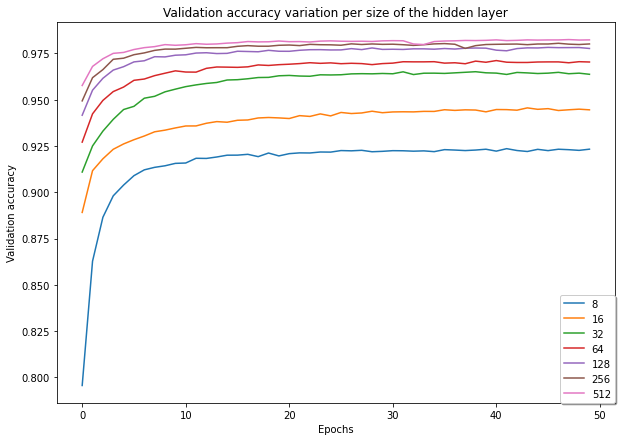

In [ ]:
fig = plt.figure(figsize=(10, 7))
multiple_line_chart(plt.gca(), 
                    None, 
                    accuracy_lines, 
                    "Validation accuracy variation per size of the hidden layer", 
                    "Epochs", 
                    "Validation accuracy")
plt.show()
plt.close(fig)

Looking at the graphs it becomes clear how much impact the hidden layer has, especially with a big size. Clearly having an hidden layer in this dataset allows the model to learn behaviour that a single-layer just can't reproduce.
From the graph we can choose the most appropriate size wich appears to be 128. Even though higher values manage to get higher accuracy, the increase is pretty small considering we're doubling the size and, in this case (single hidden layer) doubling the number of params. Let us now run the model with size 128 until convergence:

In [ ]:
multi_layer_single_hidden_model = create_multi_layer_single_hidden_model(128)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('multi_layer_single_hidden_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

multi_layer_single_hidden_train = multi_layer_single_hidden_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Model: "multi_layer_single_hidden_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
hidden (Dense)               (None, 128)               100480    
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
174/188 [==========================>...] - ETA: 0s - loss: 0.5281 - accuracy: 0.8577
Epoch 00001: val_accuracy improved from -inf to 0.92508, saving model to multi_layer_single_hidden_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.5097 - accuracy: 0.8621 - val_loss: 0.2740 - val_accuracy: 0.9251
Epoch 2/10000
183/188 

and plot the loss and accuracy:

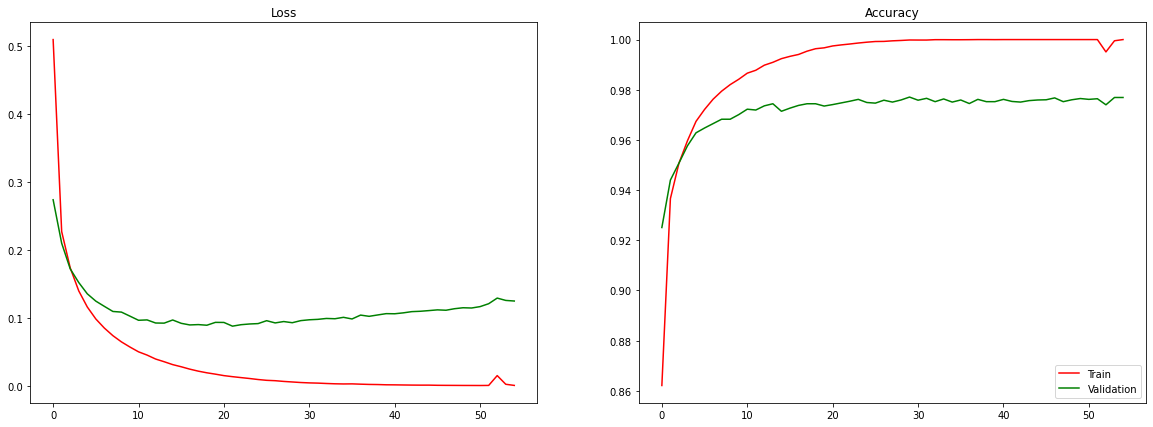

In [ ]:
plot_loss_accuracy(multi_layer_single_hidden_train.history)

And evaluate the model:

In [ ]:
multi_layer_single_hidden_model.load_weights('multi_layer_single_hidden_best.h5')
loss, acc = multi_layer_single_hidden_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0894 - accuracy: 0.9770
Accuracy: 0.9769999980926514


Already simply from including a single hidden-layer, the accuracy reaches almost 98%, obviously outperforming the single-layer. Although this is already a very good value without using CNN's, it makes uses of a single, "fat" hidden layer, that suffers greatly with the curse of dimensionality. On the contrary, a deep NN manages this curse effectively while simultaneously distributing the data through a hierarchy of conditions, great for its representability. As such we will try to divide this layer, into multiple.

##### Multiple Hidden Layers

Usually, replacing a "fat" NN with a "deep", involves a tradeoff between individual size and depth, in order to maintain the number of params. In this case however, given how much bigger the flatten layer is in comparison with the hidden layers (784 >> 128), the great majority of params come from this transition alone (100480), whilst each transition between layers contributes with less than 20% (16512), being relatively cheap to expand. Given this fact, increasing the depth is just a matter of adding more hidden-layers of the same size. Let us now plot the impact of hte number of hidden layers.
Note: The values were retrieved from the networks' summary.

In [ ]:
def create_multi_layer_multi_hidden_model(layers, name='multi_layer_multi_hidden_model'):
  multi_layer_model = tf.keras.Sequential(name=name)
  multi_layer_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  multi_layer_model.add(tf.keras.layers.Flatten(name='flatten'))
  for i in range(layers):
    multi_layer_model.add(tf.keras.layers.Dense(128, activation='relu', name='hidden{}'.format(i)))
  multi_layer_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

  multi_layer_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  multi_layer_model.summary()
  return multi_layer_model

In [ ]:
hidden_layer_count = (1, 2, 3, 4, 5)
accuracy_lines = test_model_parameter(create_multi_layer_multi_hidden_model, hidden_layer_count, 50)

Model: "multi_layer_multi_hidden_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
hidden0 (Dense)              (None, 128)               100480    
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
TEST 1/3
Epoch 1/50
188/188 [==============================] - 1s 4ms/step - loss: 0.4867 - accuracy: 0.8665 - val_loss: 0.2699 - val_accuracy: 0.9249
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: 0.2218 - accuracy: 0.9368 - val_loss: 0.2089 - val_accuracy: 0.9413
Epoch 3/50
188/188 [==============================] - 1s 3ms/step -

With the accuracy values retrieved, we plot the graph:

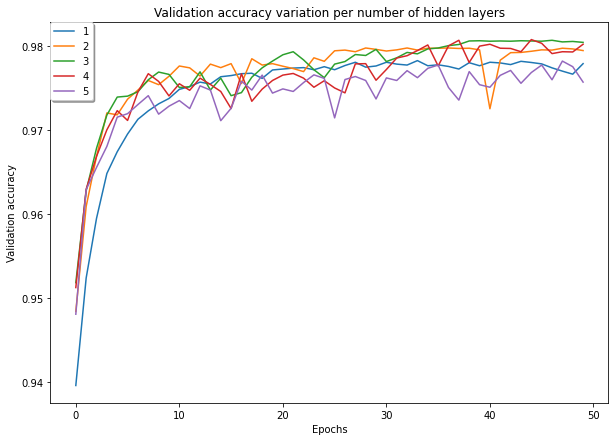

In [ ]:
fig = plt.figure(figsize=(10, 7))
multiple_line_chart(plt.gca(), 
                    None, 
                    accuracy_lines, 
                    "Validation accuracy variation per number of hidden layers", 
                    "Epochs", 
                    "Validation accuracy")
plt.show()
plt.close(fig)

Looking at the plot we can retrieve some conclussions: first of all, the model is already pretty optimized, as the variations are of less than 0.1%, resulting in some noise and fluctuations. This could be atenuated with a bigger number of tests, but would be pretty expensive. The accuracy appears to increase with the number of hidden layers. This is true for the first 4 (4 appears to reach right in the end) except for 5 hidden layers, performing worse than every other. This appears to sugest some overfitting since it is expected for accuracy to increase with the number of hidden layers, aswell as the high variations in accuracy during runtime. 3 is a safe bet as it appears to converge right at the end whilst having the highest value, but 4 appears to be catching up right in the end, perhaps even surpass it. For this reason we've decided to plot both, while running for convergence:

In [ ]:
multi_layer_3_hidden_model = create_multi_layer_multi_hidden_model(3, "multi_layer_3_hidden_model")
multi_layer_4_hidden_model = create_multi_layer_multi_hidden_model(4, "multi_layer_4_hidden_model")

Model: "multi_layer_3_hidden_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
hidden0 (Dense)              (None, 128)               100480    
_________________________________________________________________
hidden1 (Dense)              (None, 128)               16512     
_________________________________________________________________
hidden2 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________
Model: "multi_layer_4_hidden_model"
________________________________________________________________

In [ ]:
earlystop3 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, verbose=1)
earlystop4 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, verbose=1)
checkpoint3 = tf.keras.callbacks.ModelCheckpoint('multi_layer_3_hidden_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
checkpoint4 = tf.keras.callbacks.ModelCheckpoint('multi_layer_4_hidden_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

multi_layer_3_hidden_train = multi_layer_3_hidden_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop3,checkpoint3], epochs=10000, batch_size=256)
multi_layer_4_hidden_train = multi_layer_4_hidden_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop4,checkpoint4], epochs=10000, batch_size=256)

Epoch 1/10000
182/188 [============================>.] - ETA: 0s - loss: 0.4226 - accuracy: 0.8819
Epoch 00001: val_accuracy improved from -inf to 0.94325, saving model to multi_layer_3_hidden_model.h5
188/188 [==============================] - 1s 6ms/step - loss: 0.4157 - accuracy: 0.8838 - val_loss: 0.1956 - val_accuracy: 0.9433
Epoch 2/10000
180/188 [===========================>..] - ETA: 0s - loss: 0.1545 - accuracy: 0.9536
Epoch 00002: val_accuracy improved from 0.94325 to 0.95775, saving model to multi_layer_3_hidden_model.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.1537 - accuracy: 0.9538 - val_loss: 0.1435 - val_accuracy: 0.9578
Epoch 3/10000
179/188 [===========================>..] - ETA: 0s - loss: 0.1092 - accuracy: 0.9665
Epoch 00003: val_accuracy improved from 0.95775 to 0.96467, saving model to multi_layer_3_hidden_model.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.1091 - accuracy: 0.9663 - val_loss: 0.1215 - val_accuracy: 0.

and draw the plots:

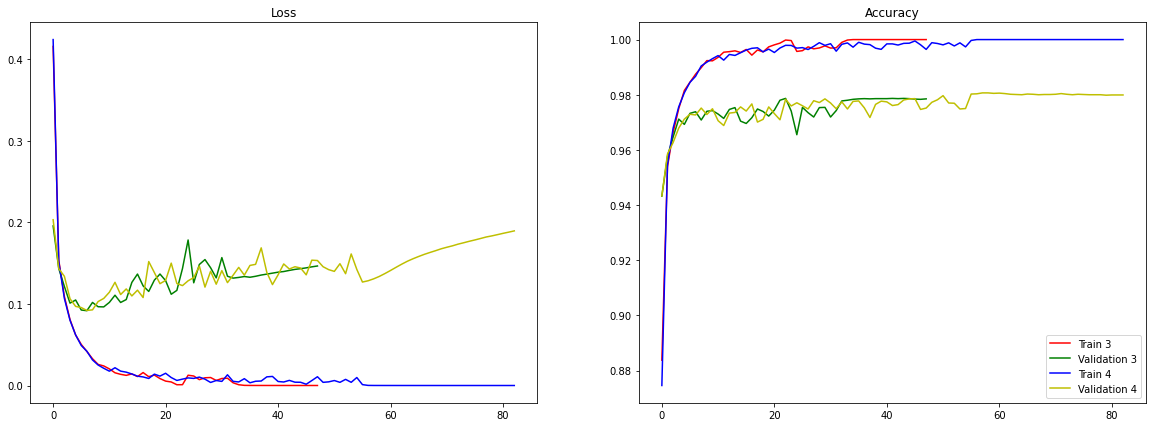

In [ ]:
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
  loss_ax.set_title('Loss')
  loss_ax.plot(multi_layer_3_hidden_train.history['loss'], '-r', label='Train 3')
  loss_ax.plot(multi_layer_3_hidden_train.history['val_loss'], '-g', label='Validation 3')
  loss_ax.plot(multi_layer_4_hidden_train.history['loss'], '-b', label='Train 4')
  loss_ax.plot(multi_layer_4_hidden_train.history['val_loss'], '-y', label='Validation 4')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(multi_layer_3_hidden_train.history['accuracy'], '-r', label='Train 3')
  acc_ax.plot(multi_layer_3_hidden_train.history['val_accuracy'], '-g', label='Validation 3')
  acc_ax.plot(multi_layer_4_hidden_train.history['accuracy'], '-b', label='Train 4')
  acc_ax.plot(multi_layer_4_hidden_train.history['val_accuracy'], '-y', label='Validation 4')
  plt.legend(loc=4)
  plt.show()

Looking at the plots, we can see that 4 hidden layers did indeed achieve a better validation accuracy, taking however nearly double the number of epochs to converge. Let us test them with the test set:

In [ ]:
multi_layer_3_hidden_model.load_weights('multi_layer_3_hidden_model.h5')
multi_layer_4_hidden_model.load_weights('multi_layer_4_hidden_model.h5')
loss, acc3 = multi_layer_3_hidden_model.evaluate(mnist_test_x, mnist_test_y)
loss, acc4 = multi_layer_4_hidden_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy for 3: {}, Accuracy for 4: {}'.format(acc3, acc4))

313/313 [==============================] - 1s 2ms/step - loss: 0.1299 - accuracy: 0.9807
Accuracy for 3: 0.9781000018119812, Accuracy for 4: 0.9807000160217285


As we can see, 4 did indeed outperform 3, reaching a solid 98% but taking double the amount of updates, so we will stick with 3 hidden layers for further testing. Let  us now see if regularization can improve this mark.

##### Regularization

To test this is pretty straightforward, we already have a satisfactory hidden layer model, so we'll add regularization to the hidden layers.

######Kernel Regularization
Let us start with kernel regularization:

In [ ]:
def create_multi_layer_kernel_reg_model(regulizer, name='multi_layer_kernel_reg_model'):
  multi_layer_model = tf.keras.Sequential(name=name)
  multi_layer_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  multi_layer_model.add(tf.keras.layers.Flatten(name='flatten'))
  for i in range(3):
    multi_layer_model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regulizer, name='hidden{}'.format(i)))
  multi_layer_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

  multi_layer_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  multi_layer_model.summary()
  return multi_layer_model

In [ ]:
regulizers = {
    "None":       None, 
    "L1 0.01":    tf.keras.regularizers.l1(0.001), 
    "L2 0.01":    tf.keras.regularizers.l2(0.001), 
    "L1 L2 0.01": tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)}
multi_layer_kernel_reg_model_accuracy_lines = test_model_parameter(create_multi_layer_kernel_reg_model, regulizers, 50)

Model: "multi_layer_kernel_reg_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
hidden0 (Dense)              (None, 128)               100480    
_________________________________________________________________
hidden1 (Dense)              (None, 128)               16512     
_________________________________________________________________
hidden2 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________
TEST 1/3
Epoch 1/50
188/188 [==============================] - 1s 4ms/step - loss: 0.4428 - accura

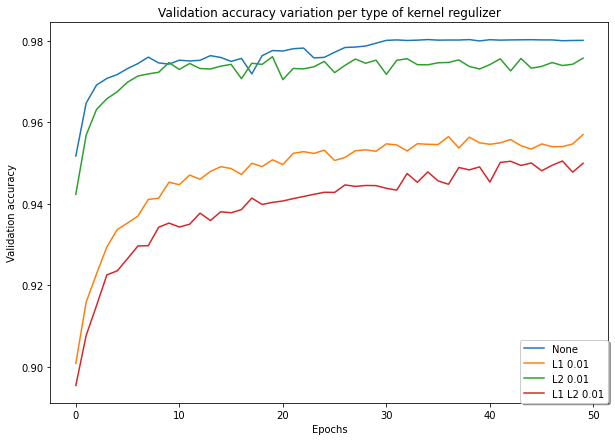

In [ ]:
fig = plt.figure(figsize=(10, 7))
multiple_line_chart(plt.gca(), 
                    None, 
                    multi_layer_kernel_reg_model_accuracy_lines, 
                    "Validation accuracy variation per type of kernel regulizer", 
                    "Epochs", 
                    "Validation accuracy")
plt.show()
plt.close(fig)

Looking at the plot we can see that kernel regularization is detrimental in this case, namely L1. For this reason we won't use it. Regardind Bias regulizers

######Bias Regularization
Moving to Bias regularization:

In [ ]:
def create_multi_layer_bias_reg_model(regulizer, name='multi_layer_bias_reg_model'):
  multi_layer_model = tf.keras.Sequential(name=name)
  multi_layer_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  multi_layer_model.add(tf.keras.layers.Flatten(name='flatten'))
  for i in range(3):
    multi_layer_model.add(tf.keras.layers.Dense(128, activation='relu', bias_regularizer=regulizer, name='hidden{}'.format(i)))
  multi_layer_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

  multi_layer_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  multi_layer_model.summary()
  return multi_layer_model

In [ ]:
regulizers = {
    "None":       None, 
    "L1 0.01":    tf.keras.regularizers.l1(0.001), 
    "L2 0.01":    tf.keras.regularizers.l2(0.001), 
    "L1 L2 0.01": tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)}
multi_layer_bias_reg_model_accuracy_lines = test_model_parameter(create_multi_layer_bias_reg_model, regulizers, 50)

Model: "multi_layer_bias_reg_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
hidden0 (Dense)              (None, 128)               100480    
_________________________________________________________________
hidden1 (Dense)              (None, 128)               16512     
_________________________________________________________________
hidden2 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________
TEST 1/3
Epoch 1/50
188/188 [==============================] - 1s 5ms/step - loss: 0.4415 - accuracy

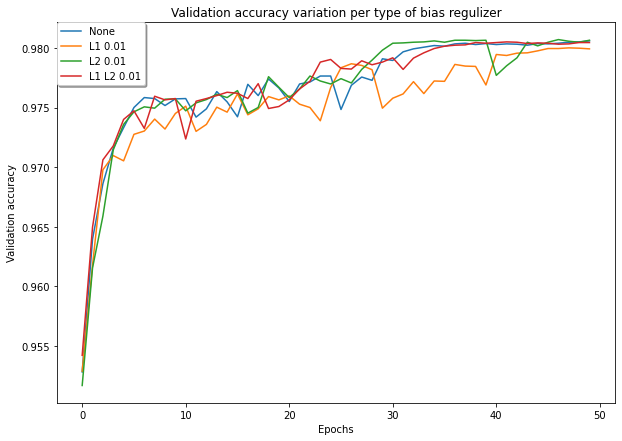

In [ ]:
fig = plt.figure(figsize=(10, 7))
multiple_line_chart(plt.gca(), 
                    None, 
                    multi_layer_bias_reg_model_accuracy_lines, 
                    "Validation accuracy variation per type of bias regulizer", 
                    "Epochs", 
                    "Validation accuracy")
plt.show()
plt.close(fig)

Looking at the plot we can see that bias regularization appears to have no impact in the final accuracy. It does however impact convergence, converging a little  bit faster with L2, whilst L1 takes considerably longer to converge. Since the benefits of L2 aren't very noticeable, we won't use any bias regularization.


######Activity Regularization
Let us now end with activity regularization:

In [ ]:
def create_multi_layer_activity_reg_model(regulizer, name='multi_layer_activity_reg_model'):
  multi_layer_model = tf.keras.Sequential(name=name)
  multi_layer_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  multi_layer_model.add(tf.keras.layers.Flatten(name='flatten'))
  for i in range(3):
    multi_layer_model.add(tf.keras.layers.Dense(128, activation='relu', activity_regularizer=regulizer, name='hidden{}'.format(i)))
  multi_layer_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

  multi_layer_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  multi_layer_model.summary()
  return multi_layer_model

In [ ]:
regulizers = {
    "None":       None, 
    "L1 0.01":    tf.keras.regularizers.l1(0.001), 
    "L2 0.01":    tf.keras.regularizers.l2(0.001), 
    "L1 L2 0.01": tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)}
multi_layer_activity_reg_model_accuracy_lines = test_model_parameter(create_multi_layer_activity_reg_model, regulizers, 50)

Model: "multi_layer_activity_reg_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
hidden0 (Dense)              (None, 128)               100480    
_________________________________________________________________
hidden1 (Dense)              (None, 128)               16512     
_________________________________________________________________
hidden2 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________
TEST 1/3
Epoch 1/50
188/188 [==============================] - 1s 4ms/step - loss: 0.4287 - accu

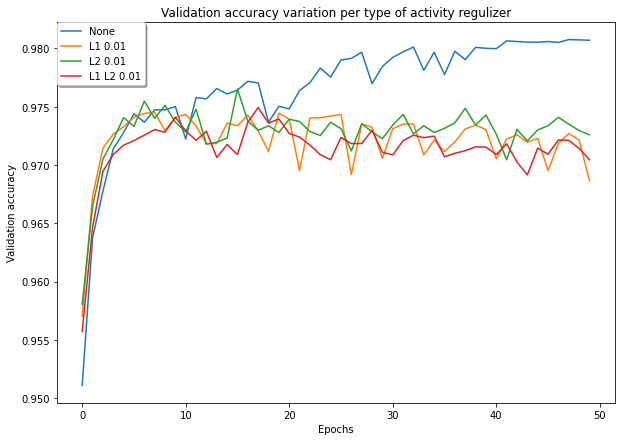

In [ ]:
fig = plt.figure(figsize=(10, 7))
multiple_line_chart(plt.gca(), 
                    None, 
                    multi_layer_activity_reg_model_accuracy_lines, 
                    "Validation accuracy variation per type of activity regulizer", 
                    "Epochs", 
                    "Validation accuracy")
plt.show()
plt.close(fig)

Looking at the plot we can see that activity regularization was exclusively detrimental in this case. For this reason we also won't use it. Regularization ended up not having a major impact in our case. This could be caused by the NN already behing pretty well optmized, but realistically is mostly a matter of further testing, namely alternating apllication for each layer and using different penalties. We're confident however that it still wouldn't have considerable impact in the accuracy rating itself, but could definetly improove convergence speeds.

#####Optimization

We've completed all testing in regards to stantard Multi-Layered NN so now it's just a matter of few tweaks or optimizations. We believe 98% is already a pretty good value without the use of Convolutional Neural Networks so we want to mostly increase convergence speed. For this, we will try batch normalization, as it could have a big impact depending on the data, using [4 hidden layers](https://colab.research.google.com/drive/1KnSJmvMyJn0KpTsu216wN7Yiy5hlgKow#scrollTo=Dd7HjISMLGwn&line=6&uniqifier=1) as a baseline:

In [ ]:
multi_layer_4_hidden_model = create_multi_layer_multi_hidden_model(4, "multi_layer_4_hidden_model") #baseline

multi_layer_norm_4_hidden_model = tf.keras.Sequential(name="multi_layer_norm_4_hidden_model")
multi_layer_norm_4_hidden_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
multi_layer_norm_4_hidden_model.add(tf.keras.layers.BatchNormalization())
multi_layer_norm_4_hidden_model.add(tf.keras.layers.Flatten(name='flatten'))
for i in range(4):
  multi_layer_norm_4_hidden_model.add(tf.keras.layers.Dense(128, activation='relu', name='hidden{}'.format(i)))
  multi_layer_norm_4_hidden_model.add(tf.keras.layers.BatchNormalization())
multi_layer_norm_4_hidden_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

multi_layer_norm_4_hidden_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
multi_layer_norm_4_hidden_model.summary()

Model: "multi_layer_4_hidden_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
hidden0 (Dense)              (None, 128)               100480    
_________________________________________________________________
hidden1 (Dense)              (None, 128)               16512     
_________________________________________________________________
hidden2 (Dense)              (None, 128)               16512     
_________________________________________________________________
hidden3 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 151,306
Trainable params: 151,306
Non-trainable params: 0
__________________________________

In [ ]:
earlystop4 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, verbose=1)
earlystop4norm = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, verbose=1)
checkpoint4 = tf.keras.callbacks.ModelCheckpoint('multi_layer_4_hidden_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
checkpoint4norm = tf.keras.callbacks.ModelCheckpoint('multi_layer_norm_4_hidden_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

multi_layer_4_hidden_train = multi_layer_4_hidden_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop4,checkpoint4], epochs=10000, batch_size=256)
multi_layer_norm_4_hidden_train = multi_layer_norm_4_hidden_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop4norm,checkpoint4norm], epochs=10000, batch_size=256)

Epoch 1/10000
172/188 [==========================>...] - ETA: 0s - loss: 0.4467 - accuracy: 0.8670
Epoch 00001: val_accuracy improved from -inf to 0.94675, saving model to multi_layer_4_hidden_model.h5
188/188 [==============================] - 1s 5ms/step - loss: 0.4252 - accuracy: 0.8730 - val_loss: 0.1861 - val_accuracy: 0.9467
Epoch 2/10000
187/188 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9567
Epoch 00002: val_accuracy improved from 0.94675 to 0.96267, saving model to multi_layer_4_hidden_model.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.1466 - accuracy: 0.9567 - val_loss: 0.1290 - val_accuracy: 0.9627
Epoch 3/10000
173/188 [==========================>...] - ETA: 0s - loss: 0.1003 - accuracy: 0.9699
Epoch 00003: val_accuracy improved from 0.96267 to 0.96800, saving model to multi_layer_4_hidden_model.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.0992 - accuracy: 0.9702 - val_loss: 0.1109 - val_accuracy: 0.

and draw the plots:

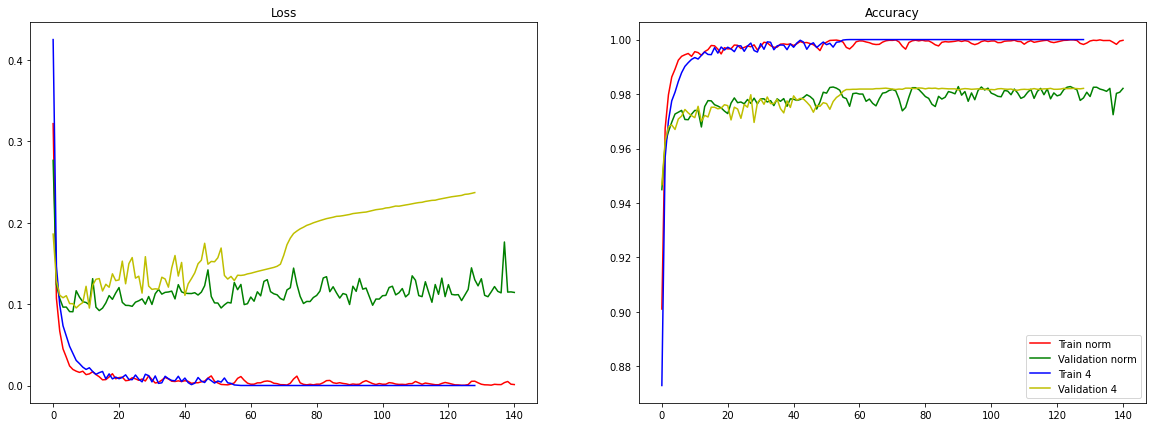

In [ ]:
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
  loss_ax.set_title('Loss')
  loss_ax.plot(multi_layer_norm_4_hidden_train.history['loss'], '-r', label='Train norm')
  loss_ax.plot(multi_layer_norm_4_hidden_train.history['val_loss'], '-g', label='Validation norm')
  loss_ax.plot(multi_layer_4_hidden_train.history['loss'], '-b', label='Train 4')
  loss_ax.plot(multi_layer_4_hidden_train.history['val_loss'], '-y', label='Validation 4')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(multi_layer_norm_4_hidden_train.history['accuracy'], '-r', label='Train norm')
  acc_ax.plot(multi_layer_norm_4_hidden_train.history['val_accuracy'], '-g', label='Validation norm')
  acc_ax.plot(multi_layer_4_hidden_train.history['accuracy'], '-b', label='Train 4')
  acc_ax.plot(multi_layer_4_hidden_train.history['val_accuracy'], '-y', label='Validation 4')
  plt.legend(loc=4)
  plt.show()

Looking at the plots it appears normalization did harm convergence, but slightly increased the speed at wich the highest accuracy value is reached, as well as the value itself.

In [ ]:
multi_layer_4_hidden_model.load_weights('multi_layer_4_hidden_model.h5')
multi_layer_norm_4_hidden_model.load_weights('multi_layer_norm_4_hidden_model.h5')
loss, acc4 = multi_layer_4_hidden_model.evaluate(mnist_test_x, mnist_test_y)
loss, acc4norm = multi_layer_norm_4_hidden_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy for baseline: {}, Accuracy for normalized: {}'.format(acc4, acc4norm))

313/313 [==============================] - 1s 2ms/step - loss: 0.0898 - accuracy: 0.9837
Accuracy for baseline: 0.9815000295639038, Accuracy for normalized: 0.9836999773979187


Just like the validate accuracy, here the normalized did outperform the baseline, reaching 98.4% wich will be our reference going forward.

## Convolutional Neural Networks

We're now moving on to CNN's, wich we expect to overperform the previous, since the data is composed of pictures. For now, we will consider a single hidden layer with size 128, wich by our tests already performs quite well, while also speeding up the next tests.

#### Single Convolutional Layer

We will start by testing a single convolutional layer. First we will consider a fixed number of filters, in order to test the impact of the kernel size:

In [ ]:
def create_single_convolutional_model(filters, kernel_size, name='single_convolutional_model'):
  multi_layer_model = tf.keras.Sequential(name=name)
  multi_layer_model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same', name='convolution_{}_{}'.format(filters, kernel_size), input_shape=mnist_info.features['image'].shape))
  multi_layer_model.add(tf.keras.layers.MaxPool2D())
  multi_layer_model.add(tf.keras.layers.Flatten(name='flatten'))
  multi_layer_model.add(tf.keras.layers.Dense(128, activation='relu', name='hidden'))
  multi_layer_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

  multi_layer_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  multi_layer_model.summary()
  return multi_layer_model

64 filters is a good start, but generates a lot of params so we will have to sacrifice testing validity here and consider a single test per parameter

In [ ]:
kernel_sizes = (2, 3, 4, 5, 6, 7, 8, 9)
accuracy_lines = test_model_parameter(lambda x: create_single_convolutional_model(64, x), kernel_sizes, 50, tests=1)

Model: "multi_layer_single_hidden_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution_64_2 (Conv2D)    (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
hidden (Dense)               (None, 128)               1605760   
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,607,370
Trainable params: 1,607,370
Non-trainable params: 0
_________________________________________________________________
TEST 1/1
Epoch 1/50
188/188 [==============================] - 1s 7ms/step - loss: 0.3262 -

With the accuracy values retrieved, we plot the graph:

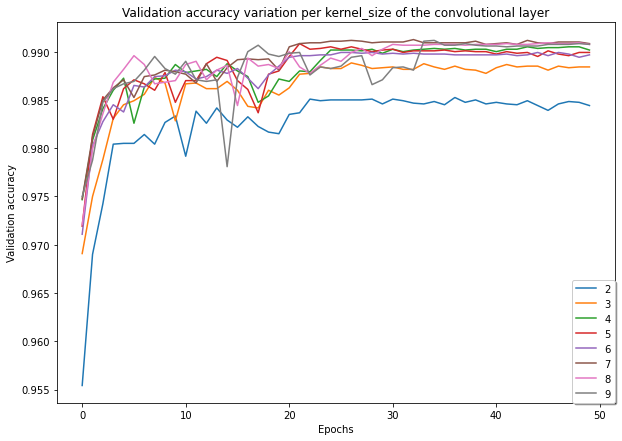

In [ ]:
fig = plt.figure(figsize=(10, 7))
multiple_line_chart(plt.gca(), 
                    None, 
                    accuracy_lines, 
                    "Validation accuracy variation per kernel_size of the convolutional layer", 
                    "Epochs", 
                    "Validation accuracy")
plt.show()
plt.close(fig)

From the graph we can see that a kernel_size of 7 is a good fit for this dataset, reaching the highest value and converging early. Let us now try to find if we can reduce the numbers of filters, since it has huge impact on performance.

In [ ]:
filters = (16, 32, 64, 128, 256)
accuracy_lines = test_model_parameter(lambda x: create_single_convolutional_model(x, 7), filters, 35, tests=1)

Model: "multi_layer_single_hidden_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution_16_7 (Conv2D)    (None, 28, 28, 16)        800       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
hidden (Dense)               (None, 128)               401536    
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 403,626
Trainable params: 403,626
Non-trainable params: 0
_________________________________________________________________
TEST 1/1
Epoch 1/35
188/188 [==============================] - 1s 5ms/step - loss: 0.3420 - acc

With the accuracy values retrieved, we plot the graph:

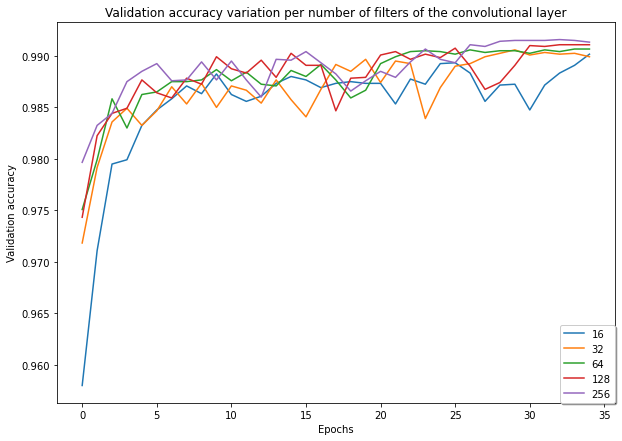

In [ ]:
fig = plt.figure(figsize=(10, 7))
multiple_line_chart(plt.gca(), 
                    None, 
                    accuracy_lines, 
                    "Validation accuracy variation per number of filters of the convolutional layer", 
                    "Epochs", 
                    "Validation accuracy")
plt.show()
plt.close(fig)

Looking at the plot, we can see that there is no point in going beyond 64, since the small improvements dont compensate doubling the computations. Below 64 the max values aren't much smaller but convergence appears slower. We will go with 32 since convergence happens only 5 epochs later, which isn't a bad payoff given that it requires half the computations. THis value will also be a better starting point for adding more layers in the next section:

#### Multiple Convolutional Layers

Let us add more Convolutional layers, to improve both performance and accuracy. Each layer of pooling halves the image, so we cant't have indefinite layers. Since the image is 28X28, after 3 pooling layers, only a 4x4 imagine is being analyzed (with padding), therefore there is no point in going further. Since each consecutive layer is working with half the image, we can increase the number of filters to compensate, for instance doubling it. Let us test this:

In [ ]:
def create_multi_convolutional_model(layers, name='multi_convolutional_model'):
  multi_layer_model = tf.keras.Sequential(name=name)
  for filters in layers:
    multi_layer_model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=7, activation='relu', padding='same', name='convolution_{}_7'.format(filters), input_shape=mnist_info.features['image'].shape))
    multi_layer_model.add(tf.keras.layers.MaxPool2D())
  multi_layer_model.add(tf.keras.layers.Flatten(name='flatten'))
  multi_layer_model.add(tf.keras.layers.Dense(128, activation='relu', name='hidden'))
  multi_layer_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

  multi_layer_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  multi_layer_model.summary()
  return multi_layer_model

In [ ]:
layers = ((32,), (32, 64), (32, 64, 128), (64,), (64, 128), (64, 128, 256)) #each tuple has the number of filters for each layer
accuracy_lines = test_model_parameter(create_multi_convolutional_model, layers, 50, tests=1)

Model: "multi_convolutional_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution_32_7 (Conv2D)    (None, 28, 28, 32)        1600      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
hidden (Dense)               (None, 128)               802944    
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 805,834
Trainable params: 805,834
Non-trainable params: 0
_________________________________________________________________
TEST 1/1
Epoch 1/50
188/188 [==============================] - 1s 5ms/step - loss: 0.2993 - accuracy:

With the accuracy values retrieved, we plot the graph:

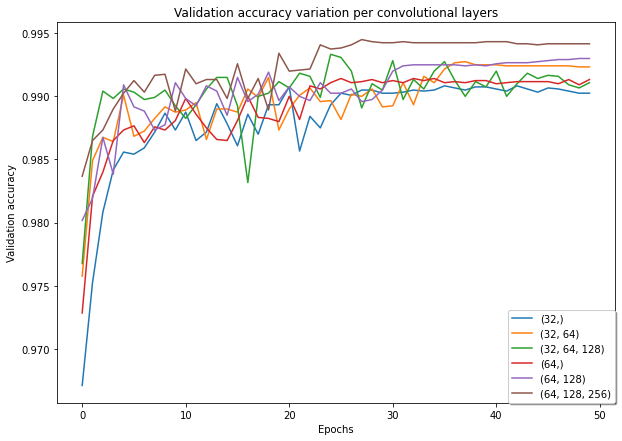

In [ ]:
fig = plt.figure(figsize=(10, 7))
multiple_line_chart(plt.gca(), 
                    None, 
                    accuracy_lines, 
                    "Validation accuracy variation per convolutional layers", 
                    "Epochs", 
                    "Validation accuracy")
plt.show()
plt.close(fig)

From the graph we can see that 3 layers, with 64, 128 and 256 filters respectively is clearly superior, both in convergence speed and accuracy. This however comes with the heavy price of high compution, namely from the huge number of params (2,306,954). Let's run it for convergence:

In [ ]:
multi_convolutional_model = create_multi_convolutional_model((64, 128, 256))

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('multi_layer_single_hidden_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

multi_convolutional_train = multi_convolutional_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Model: "multi_convolutional_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution_64_7 (Conv2D)    (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
convolution_128_7 (Conv2D)   (None, 14, 14, 128)       401536    
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
convolution_256_7 (Conv2D)   (None, 7, 7, 256)         1605888   
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)

and plot the loss and accuracy:

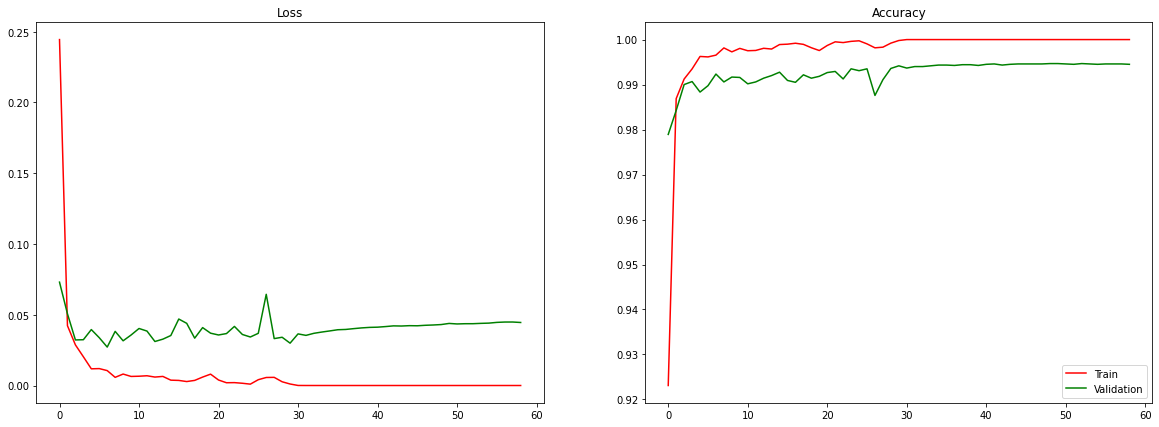

In [ ]:
plot_loss_accuracy(multi_convolutional_train.history)

And evaluate the model:

In [ ]:
multi_convolutional_model.load_weights('multi_layer_single_hidden_best.h5')
loss, acc = multi_convolutional_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 3ms/step - loss: 0.0382 - accuracy: 0.9945
Accuracy: 0.9944999814033508


99.45% is already a great accuracy, greatly surpassing the values obtained with a feed-forward arquitecture. Let us see if drop out could have a n impact here:

#### Regularization

##### Dropout

This is pretty straight forward, just a matter of adding a dropout layer in each level, and testing different vlues:

In [ ]:
def create_dropout_convolutional_model(rate, name='dropout_convolutional_model'):
  multi_layer_model = tf.keras.Sequential(name=name)
  for filters in (64, 128, 256):
    multi_layer_model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=7, activation='relu', padding='same', name='convolution_{}_7'.format(filters), input_shape=mnist_info.features['image'].shape))
    multi_layer_model.add(tf.keras.layers.MaxPool2D())
    multi_layer_model.add(tf.keras.layers.Dropout(rate))
  multi_layer_model.add(tf.keras.layers.Flatten(name='flatten'))
  multi_layer_model.add(tf.keras.layers.Dense(128, activation='relu', name='hidden'))
  multi_layer_model.add(tf.keras.layers.Dropout(rate))
  multi_layer_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

  multi_layer_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  multi_layer_model.summary()
  return multi_layer_model

In [ ]:
dropout_rates = (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)
accuracy_lines = test_model_parameter(create_dropout_convolutional_model, dropout_rates, 35, tests=1)

Model: "dropout_convolutional_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution_64_7 (Conv2D)    (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
convolution_128_7 (Conv2D)   (None, 14, 14, 128)       401536    
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
convolution_256_7 (Conv2D)   (None, 7, 

With the accuracy values retrieved, we plot the graph (0, 0.9 and 0.8 were removed to cleanup the graph):

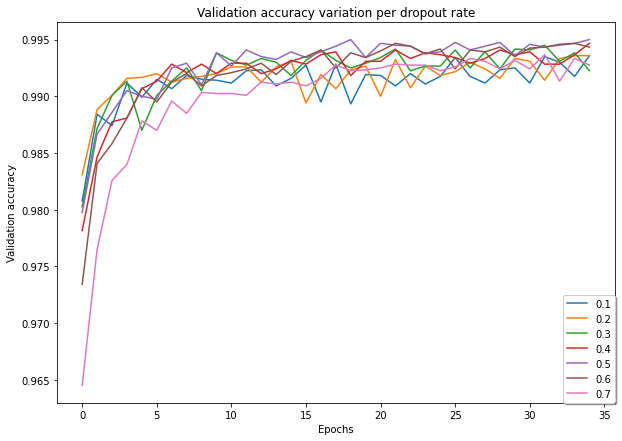

In [ ]:
fig = plt.figure(figsize=(10, 7))
multiple_line_chart(plt.gca(), 
                    None, 
                    accuracy_lines, 
                    "Validation accuracy variation per dropout rate", 
                    "Epochs", 
                    "Validation accuracy")
plt.show()
plt.close(fig)

From the graph it appears that 0.5 maximizes the accuracy, so it must be correcting a slight overfit of the model.

#### Optimization

Like the feed-forward NN's, lets see if we can improve performance by adding BatchNormalization:

In [ ]:
dropout_convolutional_model = create_dropout_convolutional_model(0.5, "multi_layer_4_hidden_model") #baseline

multi_layer_norm_model = tf.keras.Sequential(name="multi_layer_norm_model")
for filters in (64, 128, 256):
  multi_layer_norm_model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=7, activation='relu', padding='same', name='convolution_{}_7'.format(filters), input_shape=mnist_info.features['image'].shape))
  multi_layer_norm_model.add(tf.keras.layers.MaxPool2D())
  multi_layer_norm_model.add(tf.keras.layers.BatchNormalization())
  multi_layer_norm_model.add(tf.keras.layers.Dropout(0.5))
multi_layer_norm_model.add(tf.keras.layers.Flatten(name='flatten'))
multi_layer_norm_model.add(tf.keras.layers.Dense(128, activation='relu', name='hidden'))
multi_layer_norm_model.add(tf.keras.layers.BatchNormalization())
multi_layer_norm_model.add(tf.keras.layers.Dropout(0.5))
multi_layer_norm_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

multi_layer_norm_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
multi_layer_norm_model.summary()

Model: "multi_layer_4_hidden_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution_64_7 (Conv2D)    (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
convolution_128_7 (Conv2D)   (None, 14, 14, 128)       401536    
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
convolution_256_7 (Conv2D)   (None, 7, 7

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
earlystop_norm = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('dropout_convolutional_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
checkpoint_norm = tf.keras.callbacks.ModelCheckpoint('multi_layer_norm_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

dropout_convolutional_train = dropout_convolutional_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)
multi_layer_norm_train = multi_layer_norm_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop_norm,checkpoint_norm], epochs=10000, batch_size=256)

Epoch 1/10000
187/188 [============================>.] - ETA: 0s - loss: 0.0166 - accuracy: 0.9951
Epoch 00001: val_accuracy improved from -inf to 0.99425, saving model to dropout_convolutional_model.h5
188/188 [==============================] - 4s 21ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0287 - val_accuracy: 0.9942
Epoch 2/10000
187/188 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 0.9954
Epoch 00002: val_accuracy did not improve from 0.99425
188/188 [==============================] - 4s 21ms/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 0.0272 - val_accuracy: 0.9942
Epoch 3/10000
187/188 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9954
Epoch 00003: val_accuracy improved from 0.99425 to 0.99492, saving model to dropout_convolutional_model.h5
188/188 [==============================] - 4s 21ms/step - loss: 0.0137 - accuracy: 0.9954 - val_loss: 0.0293 - val_accuracy: 0.9949
Epoch 4/10000
187/188 [==================

and draw the plots:

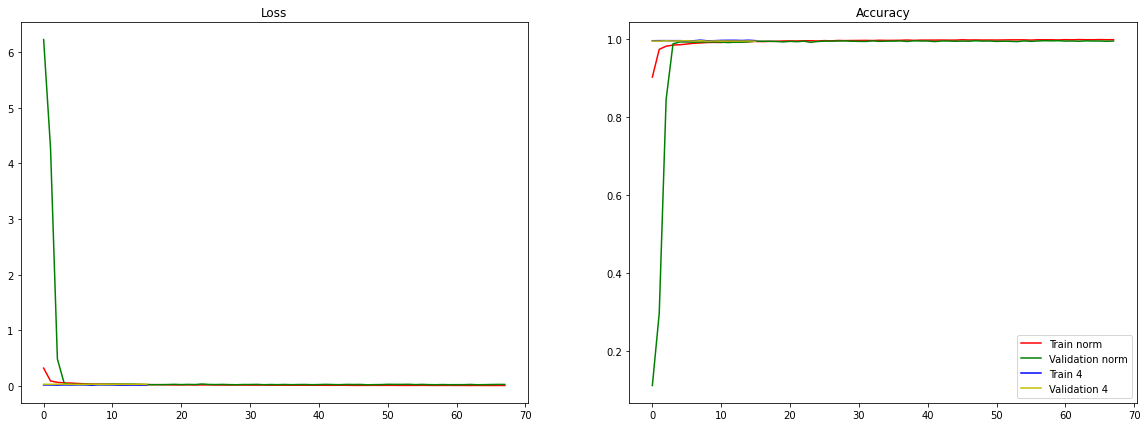

In [ ]:
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
  loss_ax.set_title('Loss')
  loss_ax.plot(multi_layer_norm_train.history['loss'], '-r', label='Train norm')
  loss_ax.plot(multi_layer_norm_train.history['val_loss'], '-g', label='Validation norm')
  loss_ax.plot(dropout_convolutional_train.history['loss'], '-b', label='Train 4')
  loss_ax.plot(dropout_convolutional_train.history['val_loss'], '-y', label='Validation 4')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(multi_layer_norm_train.history['accuracy'], '-r', label='Train norm')
  acc_ax.plot(multi_layer_norm_train.history['val_accuracy'], '-g', label='Validation norm')
  acc_ax.plot(dropout_convolutional_train.history['accuracy'], '-b', label='Train 4')
  acc_ax.plot(dropout_convolutional_train.history['val_accuracy'], '-y', label='Validation 4')
  plt.legend(loc=4)
  plt.show()

The plots show that normalization made convergence much slower, taking 3 times us much updates while still scoring less.

In [ ]:
dropout_convolutional_model.load_weights('dropout_convolutional_model.h5')
multi_layer_norm_model.load_weights('multi_layer_norm_model.h5')
loss, acc4 = dropout_convolutional_model.evaluate(mnist_test_x, mnist_test_y)
loss, acc4norm = multi_layer_norm_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy for baseline: {}, Accuracy for normalized: {}'.format(acc4, acc4norm))

313/313 [==============================] - 1s 3ms/step - loss: 0.0206 - accuracy: 0.9941
Accuracy for baseline: 0.9944000244140625, Accuracy for normalized: 0.9940999746322632


Even though the validation accuracies promissed a higher accuracy, in the test set this is not verified. Our best value is the convutional NN without dropout or normalization, at 99.45%.